In [33]:
import os
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

## ----- Imports -----
from utils import *
from modules import RNNModel, SeqDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F


DATETIME_STAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
new_dir_path = get_next_versioned_directory('rnn_training')
print(f"Created new directory: {new_dir_path}")

print(torch.__version__)
print(f"MPS available: {torch.backends.mps.is_available()}")

if torch.backends.mps.is_available():
    device = torch.device("mps")
    device_type = "mps"
    x = torch.ones(1, device=device)
    print(x)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    device_type = "cuda"
    print("CUDA device found.")
else:
    print ("Using CPU.")
    device_type = "cpu"
    device = torch.device("cpu")

SEED = 42
set_seed(SEED)

# Usage: call once before training
log_file = setup_logging(new_dir_path)
logging.info(f'Seed: {SEED}')

NUM_EPOCHS = 30
SNIPPET_LENGTH = 50
SNIPPET_OVERLAP = False
NUM_LAYERS = 1  # Number of GRU layers
CROSS_VAL = True # if True, cross validate on the split condition
# pairs of (config, roi) that are known to have good responses
good_pairs = [(3,26),(3,22),(7,31),(8,26),(8,31),(9,26),(9,27),(9,31),(11,26),
              (12,26),(13,22),(14,22),(14,23),
              (15,22),(15,23),(23,21),(24,21),(26,31),(27,31),(28,26),(28,31),
              (29,26),(29,31),(30,26),(30,27),(30,31)]

# ==================== DATA FILTERING OPTIONS ====================
# Set to None to use all, or provide a list to filter

# Filter by configs (1-31). Set to None for all configs, or e.g., [1, 2, 3] for specific ones
FILTER_CONFIGS = None  # e.g., list(range(1, 11)) for configs 1-10, or [3, 7, 15]

# Filter by neurons/ROIs (1-indexed). Set to None for all neurons, or provide a list
# You can use good_pairs to extract neurons: [n for c, n in good_pairs]
# These neurons are used for initial conditions AND as the pool for targets
FILTER_NEURONS = None  # e.g., [21, 22, 23, 26, 27, 31] for specific neurons

# Target neurons to predict (1-indexed). Must be a subset of FILTER_NEURONS.
# Set to None to predict all FILTER_NEURONS, or provide a list for specific neurons
# TARGET_NEURONS = set([pair[1] for pair in good_pairs])  # e.g., [31] to only predict neuron 31
TARGET_NEURONS = None # e.g., [26, 31] to predict neurons 26 and 31

# Filter by electrodes (0-9). Set to None for all electrodes
FILTER_ELECTRODES = None  # e.g., [0, 1, 2] for first 3 electrodes

# Filter by current levels (3, 4, 5). Set to None for all currents
FILTER_CURRENTS = None  # e.g., [5] for highest current only

# ================================================================

logging.info(f'Number of epochs {NUM_EPOCHS}')
logging.info(f'Cross validating {CROSS_VAL}')
logging.info(f'Target neurons for prediction {TARGET_NEURONS}')

checkpoint_filepath = os.path.join("rnn_training", DATETIME_STAMP, "best_model.pth")


data = scipy.io.loadmat('data.mat')
times = np.stack(data['times'][0, ...])
dfof = np.stack(data['dfof'][0, ...])
configs = np.stack( data['configs'][0, ...])
roi_used = data['roi_used']



# If filtering neurons, subset the dfof data to only include those neurons
if FILTER_NEURONS is not None:
    neuron_indices = [n - 1 for n in FILTER_NEURONS]  # Convert to 0-indexed
    dfof = np.array([session_dfof[:, neuron_indices] for session_dfof in dfof])
    logging.info(f"Filtered to {len(FILTER_NEURONS)} neurons: {FILTER_NEURONS}")
    logging.info(f"New dfof shape: {dfof.shape}")

# Validate and compute TARGET_NEURONS indices
# TARGET_NEURONS are the neurons to predict; must be subset of FILTER_NEURONS
if TARGET_NEURONS is None:
    # Default: predict all filtered neurons
    TARGET_NEURONS = FILTER_NEURONS if FILTER_NEURONS is not None else list(range(1, dfof[0].shape[1] + 1))
    target_indices = None  # Use all columns
else:
    # Validate that TARGET_NEURONS is a subset of FILTER_NEURONS (i.e. each target neuron should have an initial condition)
    if FILTER_NEURONS is not None:
        invalid_targets = set(TARGET_NEURONS) - set(FILTER_NEURONS)
        if invalid_targets:
            raise ValueError(f"TARGET_NEURONS {invalid_targets} not in FILTER_NEURONS {FILTER_NEURONS}")
        # Compute indices relative to filtered dfof
        target_indices = [FILTER_NEURONS.index(n) for n in TARGET_NEURONS]
    else:
        # No filtering, use original neuron indices (0-indexed)
        target_indices = [n - 1 for n in TARGET_NEURONS]
    logging.info(f"Target indices in filtered data: {target_indices}")

logging.info(f"configs shape: {configs.shape}")
logging.info(f"roi_used shape: {roi_used.shape}")
logging.info(f"times shape: {times.shape}")
logging.info(f"dfof shape: {dfof.shape}")

# Configs is a (n_sessions, n_rois, n_configs) array
# Times is a (n_sessions, n_trials, n_configs) array. They don't have to be serial (i.e. Channel X can be stimulated twice before Channel Y is stimulated once)
# Roi_used is a (512, 512) binary mask of which ROIs were used in the experiment
# dfof is a (n_sessions, n_timepoints, n_rois) array
# note that the sampling frequency of dfof is 30 Hz, so 30 frames is ~ 1 second of activity

Created new directory: rnn_training/20260121_112939
2.10.0.dev20251124
MPS available: True
tensor([1.], device='mps:0')
Random seed set as 42
2026-01-21 11:29:39,758 INFO: Logging started. Output file: rnn_training/20260121_112939/console.log
2026-01-21 11:29:39,759 INFO: Seed: 42
2026-01-21 11:29:39,759 INFO: Number of epochs 30
2026-01-21 11:29:39,760 INFO: Cross validating True
2026-01-21 11:29:39,760 INFO: Target neurons for prediction None
2026-01-21 11:29:39,968 INFO: configs shape: (3, 110, 31)
2026-01-21 11:29:39,969 INFO: roi_used shape: (512, 512)
2026-01-21 11:29:39,969 INFO: times shape: (3, 8, 31)
2026-01-21 11:29:39,971 INFO: dfof shape: (3, 15600, 110)


In [34]:
from utils import make_trials_df
START_OFFSET = 0 
STIM_DELAY = 10  
trials_df = make_trials_df(times, start_offset=START_OFFSET, stim_delay=STIM_DELAY)
# Display summary
logging.info(f"DataFrame shape: {trials_df.shape}")
logging.info(f"Trials per session: {trials_df.groupby('session').size().to_dict()}")
logging.info(f"Unique values:")
logging.info(f"  Sessions: {', '.join(map(str, sorted(trials_df['session'].unique())))}")
logging.info(f"  Configs: {', '.join(map(str, sorted(trials_df['config'].unique())))}")
logging.info(f"  Electrodes: {', '.join(map(str, sorted(trials_df['electrode'].unique())))}")
logging.info(f"  Currents: {', '.join(map(str, sorted(trials_df['current'].unique())))}")

# Log filter status
logging.info(f"--- Filter Status ---")
logging.info(f"  FILTER_CONFIGS: {FILTER_CONFIGS if FILTER_CONFIGS else 'All'}")
logging.info(f"  FILTER_NEURONS: {FILTER_NEURONS if FILTER_NEURONS else 'All'}")
logging.info(f"  FILTER_ELECTRODES: {FILTER_ELECTRODES if FILTER_ELECTRODES else 'All'}")
logging.info(f"  FILTER_CURRENTS: {FILTER_CURRENTS if FILTER_CURRENTS else 'All'}")

logging.info(f"trials_df head:\n{trials_df.head(10)}")
logging.info(f"--- Example queries ---")
logging.info(f"Electrode 9, Current 5: {len(trials_df[(trials_df['electrode'] == 9) & (trials_df['current'] == 5)])} trials")
logging.info(f"Session 0, Config 7: {len(trials_df[(trials_df['session'] == 0) & (trials_df['config'] == 7)])} trials")

2026-01-21 11:29:42,054 INFO: Creating trials DataFrame with START_OFFSET=0 (snippet starts 0 frames before trial_start_time)
2026-01-21 11:29:42,055 INFO: Creating trials DataFrame with STIM_DELAY=10 (stim occurs 10 frames after trial_start_time)
2026-01-21 11:29:42,063 INFO: DataFrame shape: (744, 9)
2026-01-21 11:29:42,068 INFO: Trials per session: {0: 248, 1: 248, 2: 248}
2026-01-21 11:29:42,068 INFO: Unique values:
2026-01-21 11:29:42,069 INFO:   Sessions: 0, 1, 2
2026-01-21 11:29:42,069 INFO:   Configs: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30
2026-01-21 11:29:42,070 INFO:   Electrodes: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan
2026-01-21 11:29:42,071 INFO:   Currents: 0, 3, 4, 5
2026-01-21 11:29:42,072 INFO: --- Filter Status ---
2026-01-21 11:29:42,072 INFO:   FILTER_CONFIGS: All
2026-01-21 11:29:42,072 INFO:   FILTER_NEURONS: All
2026-01-21 11:29:42,072 INFO:   FILTER_ELECTRODES: All
2026-01-21 11

This data contains single-electrode stims @ 3 current levels over 10 possible electrodes = 30 combinations + no-stim =  31 configurations total,Each configuration repeated 8 times in each of the
3 sessions. 2P imaging occurs at 30Hz per neuron.

In [35]:
# ----- Create snippets DataFrame and split data -----
from utils import make_snippets_df, snippets_df_to_arrays
from sklearn.model_selection import train_test_split

# Create snippets DataFrame from trials_df
# Stimulation timing is derived from trials_df['stim_time'] = trial_start_time + STIM_DELAY
# overlap=True creates overlapping snippets (like original make_snippets), giving ~46k+ snippets
# overlap=False only creates snippets aligned to trial stim times (~744 snippets)
# stride controls step size for overlapping snippets (1=full overlap, length=non-overlapping)
SNIPPET_STRIDE = 1  # Set to SNIPPET_LENGTH for non-overlapping, only if SNIPPET_OVERLAP is True (otherwise ignored)

snippets_df = make_snippets_df(trials_df, dfof, SNIPPET_LENGTH, 
                                overlap=SNIPPET_OVERLAP, stride=SNIPPET_STRIDE)

logging.info(f"Snippets DataFrame shape: {snippets_df.shape}")
logging.info(f"Valid snippets: {snippets_df['valid'].sum()}")
logging.info(f"Snippets with stim at t=0: {snippets_df['stim_at_t0'].sum()}")

# ==================== SPLIT STRATEGY ===================
# Choose one of: 'random', 'session', 'trial', 'config', 'electrode', 'current', 'stim_at_t0'
SPLIT_STRATEGY = 'trial'

# For 'session': which sessions to hold out for test (only valid if SPLIT_STRATEGY=='session')
HOLDOUT_SESSIONS = []  # e.g., session 2 as test (range 0-2 inclusive)

# For 'trial': which trial indices to hold out (only valid if SPLIT_STRATEGY=='trial')
HOLDOUT_TRIALS = [0]  # e.g., trials 1 and 7 as test (0-indexed, range 0-7 inclusive)

# For 'config': which configs to hold out (only valid if SPLIT_STRATEGY=='config')
HOLDOUT_CONFIGS = []  # e.g., configs 28-30 as test; range is 1-31 (inclusive)

# For 'electrode': which electrodes to hold out (only valid if SPLIT_STRATEGY=='electrode')
HOLDOUT_ELECTRODES = []  # e.g., electrode 9 as test (range 0-9 inclusive and None, which would select config 31))

# For 'current': which current levels to hold out (only valid if SPLIT_STRATEGY=='current')
HOLDOUT_CURRENTS = []  # e.g., highest current as test (either 0, 3, 4, or 5)

# ========================================================
VAL_SIZE = 0.15
valid_df = snippets_df[snippets_df['valid']].copy()
print (valid_df.columns)
# Random split proportions if using random SPLIT_STRATEGY
# Get sessions
sessions = sorted(valid_df['session'].unique())
train_df, val_df, test_df = create_split_dfs(
    split_strategy=SPLIT_STRATEGY,
    valid_df=valid_df,
    trials_df=trials_df,
    sessions=sessions,
    snippet_length=SNIPPET_LENGTH,
    val_size=VAL_SIZE,
    seed=SEED,
    holdout_sessions=HOLDOUT_SESSIONS,
    holdout_trials=HOLDOUT_TRIALS,
    holdout_configs=HOLDOUT_CONFIGS,
    holdout_electrodes=HOLDOUT_ELECTRODES,
    holdout_currents=HOLDOUT_CURRENTS,
 )

for dataframe, flag in ((train_df, False), (val_df, False), (test_df, True)):
    dataframe['is_test'] = flag

valid_df['is_test'] = valid_df.index.isin(test_df.index)
valid_df.sort_values(by=['first_config', 'session', 'first_trial'], inplace=True)
print ("Electrodes: ", valid_df["first_electrode"].unique())
print ("Currents: ", valid_df["first_current"].unique())
print ("Configs: ", valid_df['first_config'].unique())

2026-01-21 11:29:43,860 INFO: Snippets DataFrame shape: (744, 18)
2026-01-21 11:29:43,861 INFO: Valid snippets: 744
2026-01-21 11:29:43,862 INFO: Snippets with stim at t=0: 0
Index(['session', 'snippet_start', 'first_config', 'first_electrode',
       'first_current', 'first_trial', 'first_stim_time', 'all_configs',
       'all_electrodes', 'all_currents', 'all_trials', 'has_stim',
       'stim_at_t0', 'num_stims', 'initial_condition', 'activity_snippet',
       'stim_snippet', 'valid'],
      dtype='object')
2026-01-21 11:29:43,877 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-21 11:29:43,879 INFO: === Split Summary (trial) ===
2026-01-21 11:29:43,879 INFO: Train: 553 samples (74.3%)
2026-01-21 11:29:43,879 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:29:43,880 INFO: Val: 98 samples (13.2%)
2026-01-21 11:29:43,880 INFO: Test: 93 samples (12.5%)
2026-01-21 11:29:43,881 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
Elec

/var/folders/38/_qz39whn0hngmtsmjg9byfbr0000gn/T/ipykernel_28573/311572879.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['is_test'] = flag


In [36]:
from utils import debug_stim_alignment
debug_stim_alignment(START_OFFSET, STIM_DELAY, SNIPPET_LENGTH, SNIPPET_OVERLAP, trials_df, train_df)


=== DEBUG: Checking stim alignment ===
START_OFFSET = 0
STIM_DELAY = 10
SNIPPET_LENGTH = 50
SNIPPET_OVERLAP = False
session                  0
trial                    0
config                   1
electrode              0.0
current                  3
trial_start_time      2811
stim_time           2821.0
start_time            2811
is_stim               True
Name: 0, dtype: object

First trial: session=0, config=1
  trial_start_time = 2811
  stim_time = 2821.0 (should be trial_start_time + STIM_DELAY)
  start_time = 2811 (snippet starts here)
  Expected stim at snippet frame: 10.0

--- First train snippet from _df ---
session                                                              2
snippet_start                                                    12461
first_config                                                        21
first_electrode                                                    6.0
first_current                                                        5
first_trial          


=== Trial vs Snippet Alignment Summary ===
STIM_DELAY = 10 (frames after trial start when stim occurs)
START_OFFSET = 0 (snippet starts this many frames before stim)

Expected: stim_time = start_time + STIM_DELAY
Expected: snippet_start = stim_time - START_OFFSET (when stim_at_t0=True)

In snippets with stim_at_t0=True, first_stim_time should be ~0

Test snippets: 93, unique trials in test: [np.int64(0)]


/Users/shubhom/Documents/closed_loop_stim/one_stim_channel/viz.py:501: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_trials = trials_df.groupby('session').apply(lambda x: x.sample(min(3, len(x)), random_state=seed)).reset_index(drop=True)


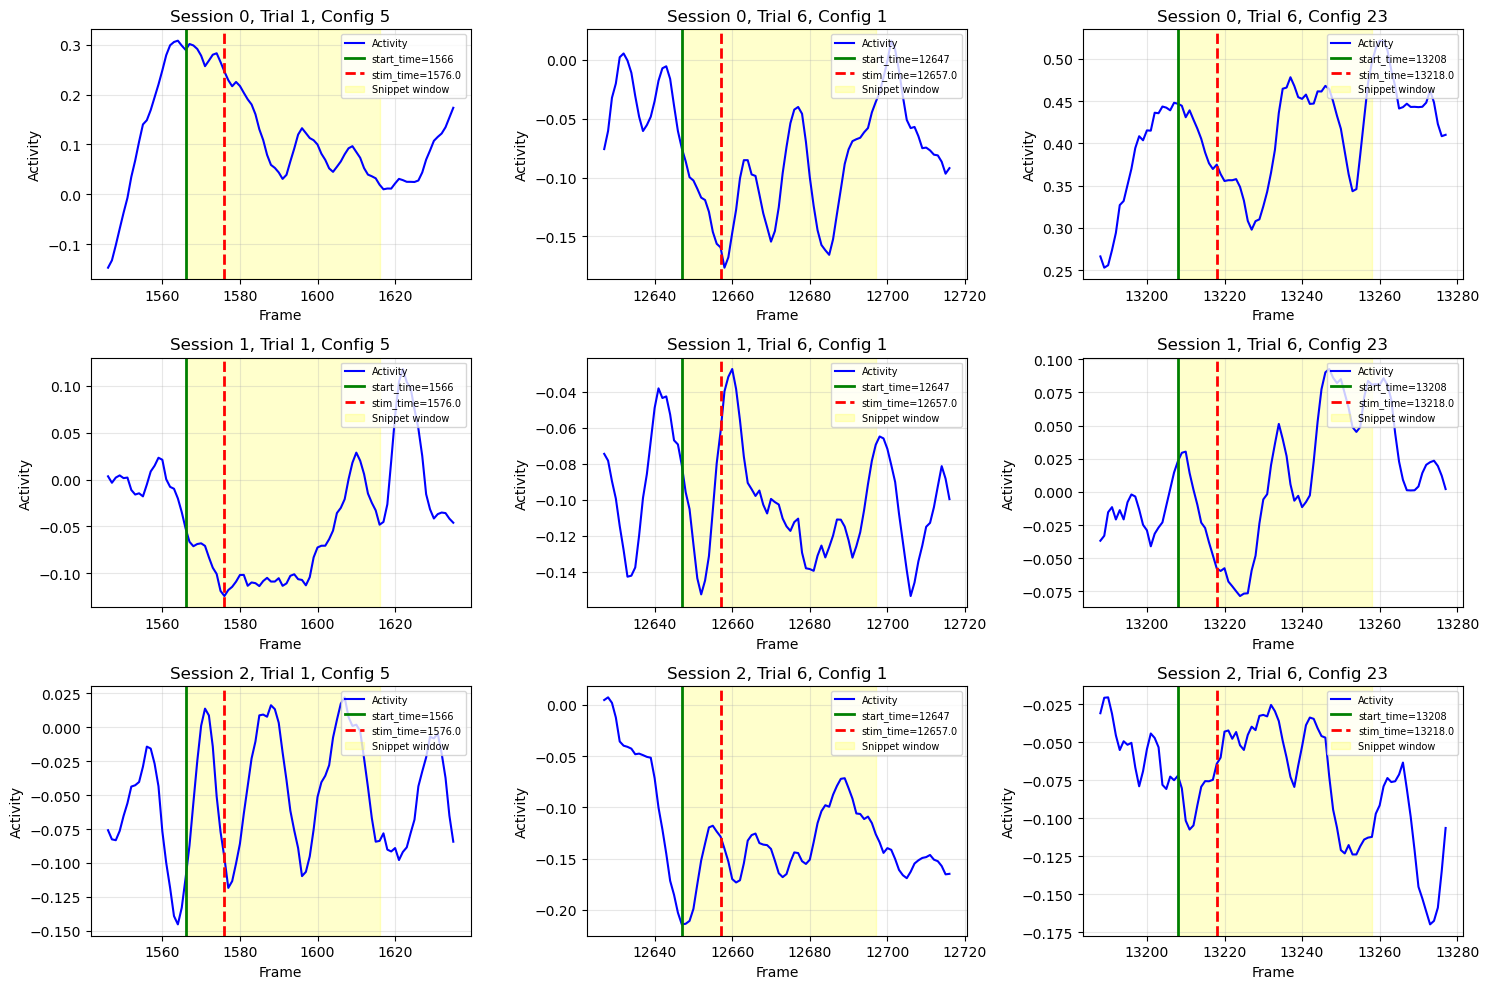

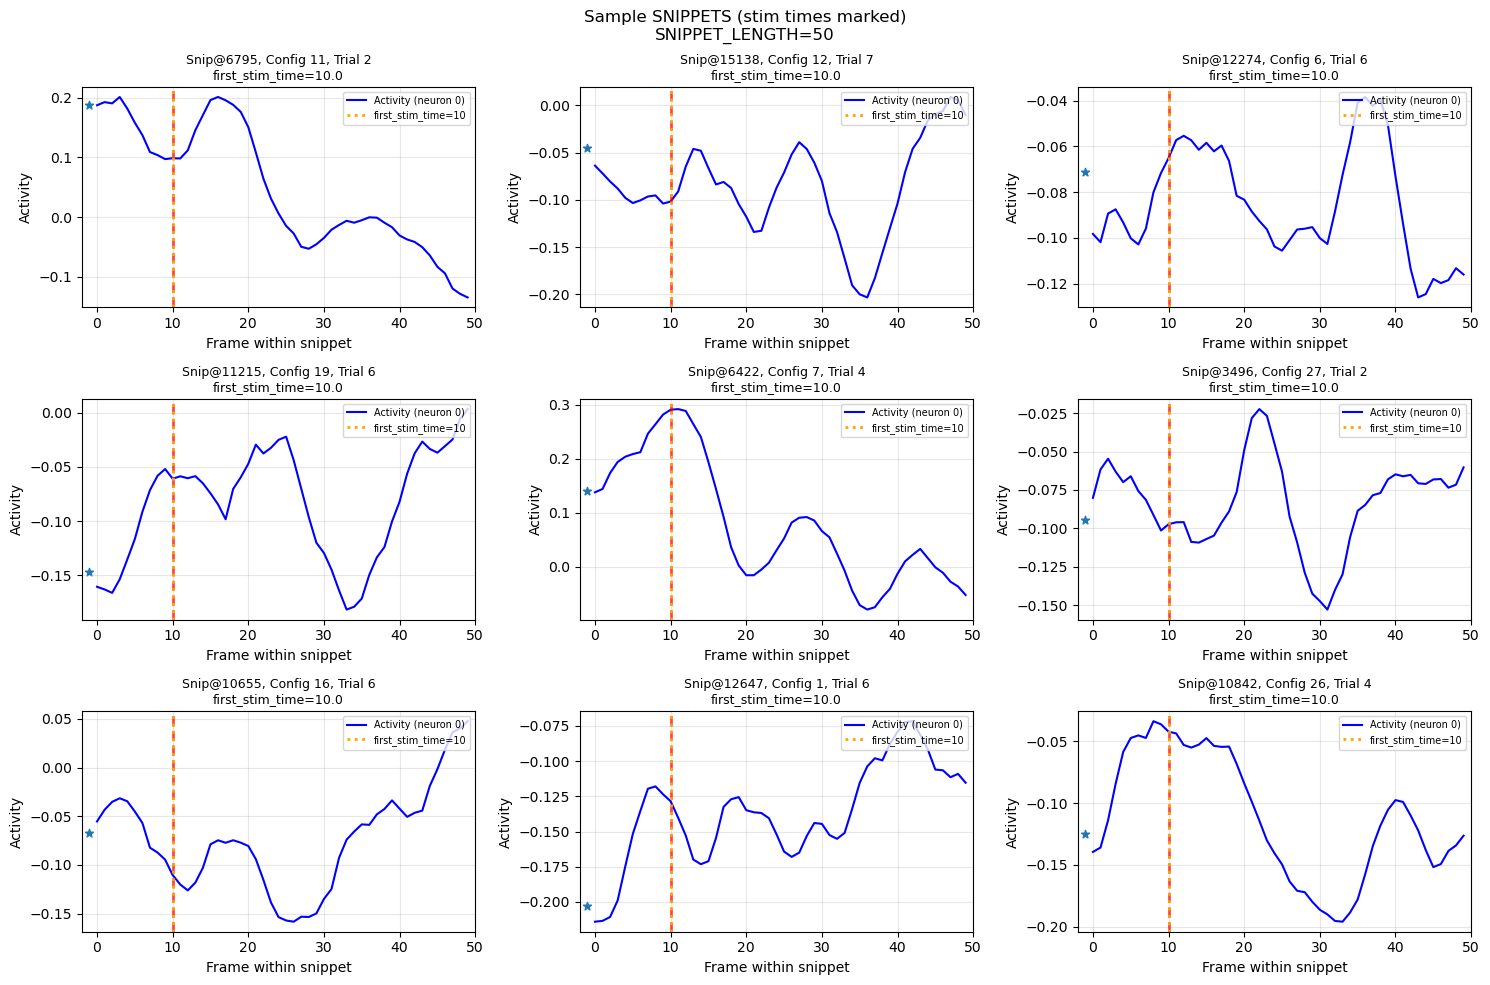

In [37]:
from viz import show_trials_snippets_sample

# Print summary for debugging
print("\n=== Trial vs Snippet Alignment Summary ===")
print(f"STIM_DELAY = {STIM_DELAY} (frames after trial start when stim occurs)")
print(f"START_OFFSET = {START_OFFSET} (snippet starts this many frames before stim)")
print(f"\nExpected: stim_time = start_time + STIM_DELAY")
print(f"Expected: snippet_start = stim_time - START_OFFSET (when stim_at_t0=True)")
print(f"\nIn snippets with stim_at_t0=True, first_stim_time should be ~0")
print(f"\nTest snippets: {len(test_df)}, unique trials in test: {sorted(test_df['first_trial'].dropna().unique())}")
show_trials_snippets_sample(trials_df, train_df, dfof, SNIPPET_LENGTH, seed=SEED, savepath=new_dir_path)

In [38]:
# Pass target_indices to SeqDataset to select which neurons to predict
# Initial conditions use all FILTER_NEURONS, predictions use only TARGET_NEURONS
# This will be replaced when cross validating; here for visualization purposes
train_ds = SeqDataset(df=train_df, target_indices=target_indices)
val_ds = SeqDataset(df=val_df, target_indices=target_indices)
test_ds = SeqDataset(df=test_df, target_indices=target_indices)



# --- prepare datasets using DataFrame-based SeqDataset ---
batch_size = 4
logging.info(f'Batch size: {batch_size}')


train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count() - 1, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, pin_memory=True)

logging.info("Dataset sizes -> train: %d, val: %d, test: %d",
             len(train_ds), len(val_ds), len(test_ds))
logging.info(f"Target neurons: {TARGET_NEURONS} (indices: {target_indices})")


# --- model, loss, optimizer ---
# Get dimensions from the dataset
sample_stim, _ = train_ds[0]
input_size = sample_stim[0].shape[1]  # n_electrodes
# Note: initial_conds uses all FILTER_NEURONS, but output_size matches TARGET_NEURONS
output_size = train_ds.Y.shape[2]     # n_target_neurons
initial_cond_size = train_ds.initial_conds.shape[1]  # n_filter_neurons

N_UNITS = 32  # hidden state size
LOSS_TYPE = "mse"  # Options: 'mse', 'mae', 'weighted_mae'
LR = 0.001
REGULARIZE = 0

# Create model: initial_cond_size uses all FILTER_NEURONS, output_size uses TARGET_NEURONS
model = RNNModel(input_size=input_size, units=N_UNITS, output_size=output_size, 
                 num_layers=NUM_LAYERS, initial_cond_size=initial_cond_size).to(device)
logging.info(f'Model architecture:\n{model}')
logging.info(f'Train input size: {input_size}')
logging.info(f'Initial condition size: {initial_cond_size} (FILTER_NEURONS)')
logging.info(f'Train output size: {output_size} (TARGET_NEURONS)')
logging.info(f'Hidden state size: {N_UNITS}')
logging.info(f'Number of GRU layers: {NUM_LAYERS}')


if LOSS_TYPE == 'mae':
    criterion = nn.MSELoss()
elif LOSS_TYPE == 'mae':
    criterion = nn.L1Loss()
elif LOSS_TYPE == 'weighted_mae':
    from modules import WeightedMAELoss
    # Weighted loss parameters
    STIM_WEIGHT = 5.0   # How much more to weight stim-adjacent frames
    STIM_WINDOW = 15    # Frames after stim to upweight (~0.5 sec at 30Hz)
    WEIGHT_DECAY = 'none'  # 'none', 'linear', or 'exp'
    criterion = WeightedMAELoss(stim_weight=STIM_WEIGHT, window=STIM_WINDOW, decay=WEIGHT_DECAY)
    logging.info(f'Using WeightedMAELoss: stim_weight={STIM_WEIGHT}, window={STIM_WINDOW}, decay={WEIGHT_DECAY}')
else:
    criterion = nn.MSELoss()

OPTIMIZER = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=REGULARIZE)
logging.info(f"Learning rate {LR}")
logging.info(f"Optimizer: {OPTIMIZER}")
logging.info(f"Loss type: {LOSS_TYPE}")
logging.info(f"Regularization coefficient: {REGULARIZE}")

# print (f'Example input: {example_input[0]}, \n\nactivity_initial: {example_input[1]}')


2026-01-21 11:29:59,192 INFO: Batch size: 4
2026-01-21 11:29:59,196 INFO: Dataset sizes -> train: 553, val: 98, test: 93
2026-01-21 11:29:59,196 INFO: Target neurons: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110] (indices: None)
2026-01-21 11:29:59,204 INFO: Model architecture:
RNNModel(
  (initial_state_projection): Linear(in_features=110, out_features=32, bias=True)
  (rnn): GRU(10, 32, batch_first=True)
  (dense): Sequential(
    (0): Linear(in_features=32, out_features=110, bias=True)
  )
)
2026-01-21 11:29:59,204 INFO: Train input size: 10
2026-01-21 11:29:59,204 INFO: Initial condition size

## Visualize train/val/test split across sessions as timelines
###  Goal: verify that test snippets don't temporally overlap with train snippets

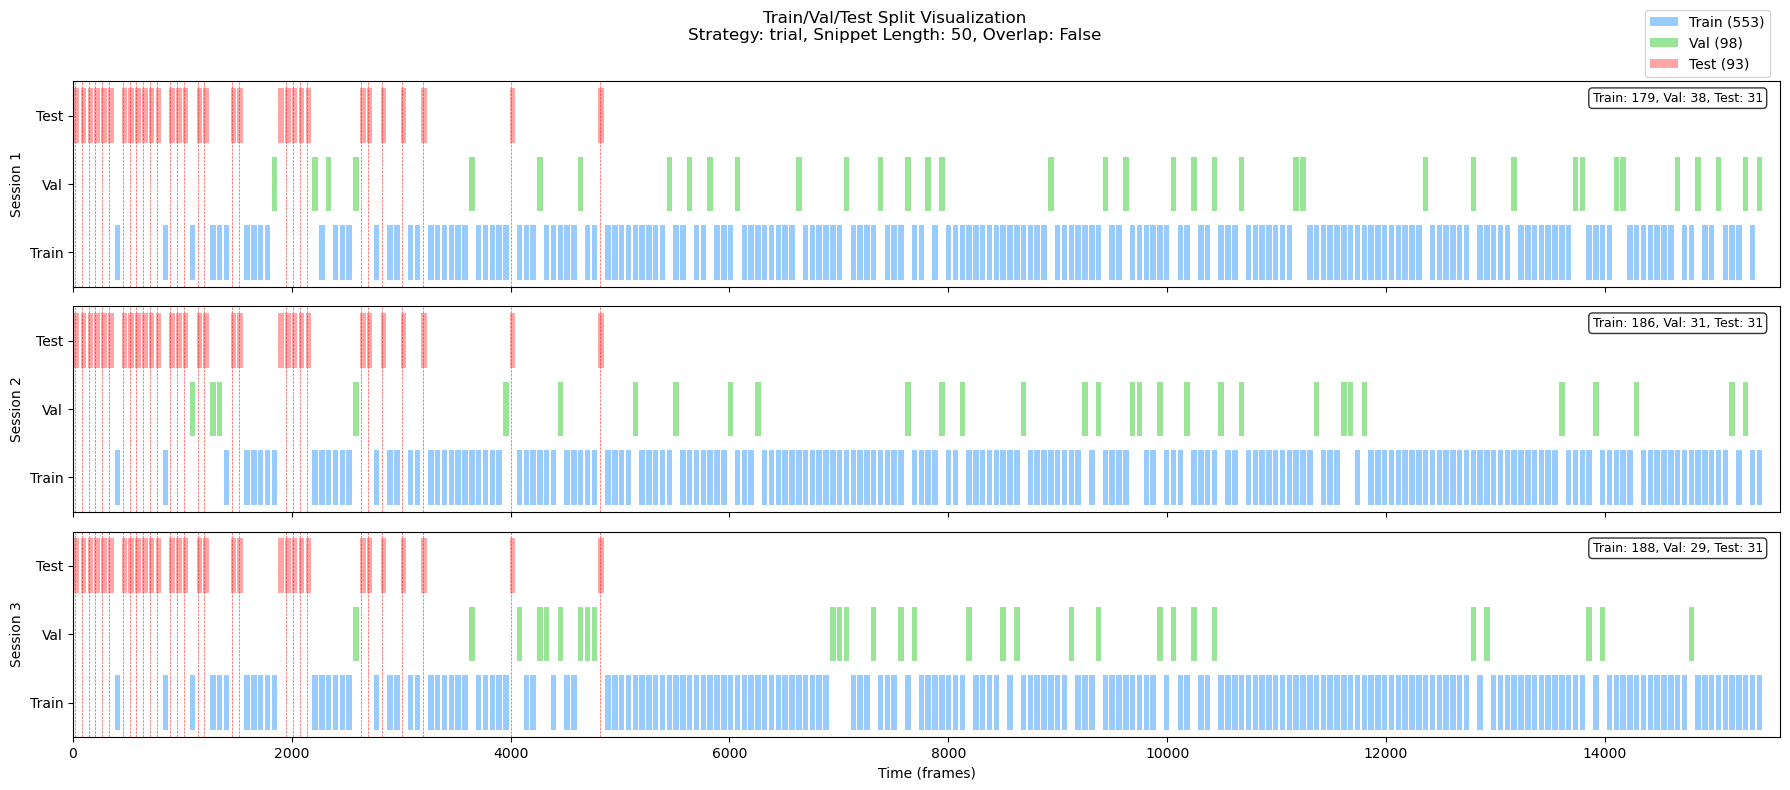


=== Overlap Analysis ===
Session 0: Train frames: 8950, Test frames: 1550, Overlap: 0 frames (0.0% of test)
Session 1: Train frames: 9300, Test frames: 1550, Overlap: 0 frames (0.0% of test)
Session 2: Train frames: 9400, Test frames: 1550, Overlap: 0 frames (0.0% of test)
Visualization saved to: rnn_training/20260121_112939/split_visualization.png


In [39]:
from viz import plot_split_visualization
    
# Call the visualization helper
plot_split_visualization(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    dfof=dfof,
    snippet_length=SNIPPET_LENGTH,
    split_strategy=SPLIT_STRATEGY,
    snippet_overlap=SNIPPET_OVERLAP,
    holdout_trials=HOLDOUT_TRIALS if 'HOLDOUT_TRIALS' in globals() else [],
    trials_df=trials_df,
    output_dir=new_dir_path,
    num_sessions=3,
    figure_size=(18, 8),
    bar_height=0.8,
    dpi=150,
 )

In [40]:
from tqdm.notebook import tqdm
import time
import torch
import logging

def train_with_progress(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    checkpoint_path,
    device,
    device_type,   # e.g. "cuda", "mps", "cpu"
    num_epochs,
    loss_type=None,
    use_amp=True,
    max_grad_norm=1.0,
    early_stop_patience=5,
    min_epochs_before_early_stop=5,
):
    """
    Training loop with:
      - tqdm epoch + batch progress
      - AMP (autocast + GradScaler) when supported
      - optional weighted loss: criterion(outputs, targets, inputs)
      - validation + best-checkpoint save
      - simple early stopping on 'patience' consecutive non-improvements
    """
    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": []}

    # AMP support varies by device; GradScaler is meaningful on CUDA.
    amp_enabled = bool(use_amp) and (device_type in ("cuda",))
    scaler = torch.amp.GradScaler(enabled=amp_enabled)

    def compute_loss(outputs, targets, inputs):
        if loss_type == "weighted_mae":
            return criterion(outputs, targets, inputs)
        return criterion(outputs, targets)

    epoch_pbar = tqdm(range(1, num_epochs + 1), desc="Epochs", unit="ep")

    for epoch in epoch_pbar:
        t0 = time.perf_counter()

        # -------------------- train --------------------
        model.train()
        running_loss = 0.0
        n_train = 0

        for (inputs, activity_initial), targets in tqdm(
            train_loader, desc=f"Epoch {epoch} Train", leave=False, unit="batch"
        ):
            inputs = inputs.to(device, non_blocking=True)
            activity_initial = activity_initial.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=amp_enabled):
                outputs = model((inputs, activity_initial))
                loss = compute_loss(outputs, targets, inputs)

            if amp_enabled:
                scaler.scale(loss).backward()
                # unscale before clipping so clip is in true scale
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                optimizer.step()

            bs = inputs.size(0)
            running_loss += loss.item() * bs
            n_train += bs

        train_loss = running_loss / max(n_train, 1)
        history["train_loss"].append(train_loss)
        logging.info(f"Epoch {epoch} Train loss: {train_loss:.6f}")

        # -------------------- val --------------------
        model.eval()
        val_running = 0.0
        n_val = 0

        with torch.no_grad():
            for (inputs, activity_initial), targets in tqdm(
                val_loader, desc=f"Epoch {epoch} Val", leave=False, unit="batch"
            ):
                inputs = inputs.to(device, non_blocking=True)
                activity_initial = activity_initial.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)

                with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=amp_enabled):
                    outputs = model((inputs, activity_initial))
                    vloss = compute_loss(outputs, targets, inputs)

                bs = inputs.size(0)
                val_running += vloss.item() * bs
                n_val += bs

        val_loss = val_running / max(n_val, 1)
        history["val_loss"].append(val_loss)
        logging.info(f"Epoch {epoch} Validation loss: {val_loss:.6f}")

        # checkpoint best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            logging.info(f"Saved best model (val={best_val_loss:.6f}) -> {checkpoint_path}")

        # early stopping: no improvement for `patience` consecutive epochs
        if epoch > min_epochs_before_early_stop and len(history["val_loss"]) >= (early_stop_patience + 1):
            recent = history["val_loss"][-(early_stop_patience + 1):]
            no_improve = all(recent[i] >= recent[i - 1] for i in range(1, len(recent)))
            if no_improve:
                logging.info(
                    f"Early stopping: val loss did not improve for {early_stop_patience} consecutive epochs."
                )
                epoch_time = time.perf_counter() - t0
                epoch_pbar.set_postfix(
                    {"train": f"{train_loss:.6f}", "val": f"{val_loss:.6f}", "sec": f"{epoch_time:.2f}"}
                )
                break

        epoch_time = time.perf_counter() - t0
        epoch_pbar.set_postfix(
            {"train": f"{train_loss:.6f}", "val": f"{val_loss:.6f}", "sec": f"{epoch_time:.2f}"}
        )

    return history, best_val_loss

use_amp = True

# history, best_val_loss = train_with_progress(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     criterion=criterion,
#     optimizer=OPTIMIZER,  
#     checkpoint_path=checkpoint_filepath,
#     device=device,
#     device_type=device_type,   # "cuda" / "mps" / "cpu"
#     num_epochs=NUM_EPOCHS,
#     loss_type=LOSS_TYPE,
#     use_amp=use_amp,
# )


## Calculate test-error

In [41]:
import os
import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import logging
import json

from utils import get_inputs_outputs_targets, get_model_error, create_split_dfs
from modules import RNNModel, SeqDataset

# ----- Hyperparameters (collected in dict for reproducibility) -----
CV_HPARAMS = {
    'split_strategy': SPLIT_STRATEGY,
    'snippet_length': SNIPPET_LENGTH,
    'snippet_overlap': SNIPPET_OVERLAP,
    'snippet_stride': SNIPPET_STRIDE,
    'val_size': VAL_SIZE,
    'seed': SEED,
    'batch_size': batch_size,
    'n_units': N_UNITS,
    'num_layers': NUM_LAYERS,
    'loss_type': LOSS_TYPE,
    'lr': LR,
    'regularize': REGULARIZE,
    'num_epochs': NUM_EPOCHS,
    'early_stop_patience': 5,
    'use_amp': use_amp,
}

logging.info(f"=== Cross-Validation Hyperparameters ===")
for k, v in CV_HPARAMS.items():
    logging.info(f"  {k}: {v}")

# ----- Determine fold elements based on split strategy -----
if CV_HPARAMS['split_strategy'] == 'trial':
    fold_elements = list(range(8))  # trials 0-7
    holdout_key = 'holdout_trials'
elif CV_HPARAMS['split_strategy'] == 'session':
    fold_elements = list(range(3))  # sessions 0-2
    holdout_key = 'holdout_sessions'
elif CV_HPARAMS['split_strategy'] == 'config':
    fold_elements = list(range(1, 32))  # configs 1-31
    holdout_key = 'holdout_configs'
elif CV_HPARAMS['split_strategy'] == 'electrode':
    fold_elements = list(range(10)) + [None]  # electrodes 0-9 + None (config 31)
    holdout_key = 'holdout_electrodes'
elif CV_HPARAMS['split_strategy'] == 'current':
    fold_elements = [0, 3, 4, 5]  # current levels (0 = no stim)
    holdout_key = 'holdout_currents'
else:
    raise ValueError(f"Cross-validation not supported for strategy: {CV_HPARAMS['split_strategy']}")

n_folds = len(fold_elements)
logging.info(f"Running {n_folds}-fold CV on '{CV_HPARAMS['split_strategy']}' with elements: {fold_elements}")

# ----- Cross-validation loop -----
cv_results = []
for fold_idx, holdout_element in enumerate(tqdm(fold_elements, desc="CV Folds")):
    logging.info(f"\n{'='*60}")
    logging.info(f"FOLD {fold_idx + 1}/{n_folds}: Holding out {CV_HPARAMS['split_strategy']}={holdout_element}")
    logging.info(f"{'='*60}")
    
    # Build holdout kwargs: only set the relevant holdout, others empty
    holdout_kwargs = {
        'holdout_sessions': [],
        'holdout_trials': [],
        'holdout_configs': [],
        'holdout_electrodes': [],
        'holdout_currents': [],
    }
    holdout_kwargs[holdout_key] = [holdout_element]
    
    # Create train/val/test splits for this fold
    fold_train_df, fold_val_df, fold_test_df = create_split_dfs(
        split_strategy=CV_HPARAMS['split_strategy'],
        valid_df=valid_df.copy(),
        trials_df=trials_df,
        sessions=sessions,
        snippet_length=CV_HPARAMS['snippet_length'],
        val_size=CV_HPARAMS['val_size'],
        seed=CV_HPARAMS['seed'],
        **holdout_kwargs
    )
    
    # Skip fold if test set is empty
    if len(fold_test_df) == 0:
        logging.warning(f"Fold {fold_idx + 1}: Empty test set for holdout={holdout_element}, skipping.")
        continue
    
    logging.info(f"Fold {fold_idx + 1} sizes: train={len(fold_train_df)}, val={len(fold_val_df)}, test={len(fold_test_df)}")
    
    # Create datasets and loaders
    fold_train_ds = SeqDataset(df=fold_train_df, target_indices=target_indices)
    fold_val_ds = SeqDataset(df=fold_val_df, target_indices=target_indices)
    fold_test_ds = SeqDataset(df=fold_test_df, target_indices=target_indices)
    
    fold_train_loader = DataLoader(fold_train_ds, batch_size=CV_HPARAMS['batch_size'], 
                                   shuffle=True, num_workers=max(1, os.cpu_count() - 1), pin_memory=True)
    fold_val_loader = DataLoader(fold_val_ds, batch_size=CV_HPARAMS['batch_size'], 
                                 shuffle=False, pin_memory=True)
    fold_test_loader = DataLoader(fold_test_ds, batch_size=CV_HPARAMS['batch_size'], 
                                  shuffle=False, pin_memory=True)
    
    # Initialize fresh model for this fold
    fold_model = RNNModel(
        input_size=input_size, 
        units=CV_HPARAMS['n_units'], 
        output_size=output_size,
        num_layers=CV_HPARAMS['num_layers'], 
        initial_cond_size=initial_cond_size
    ).to(device)
    
    # Loss and optimizer
    if CV_HPARAMS['loss_type'] == 'mae':
        fold_criterion = nn.L1Loss()
    elif CV_HPARAMS['loss_type'] == 'weighted_mae':
        from modules import WeightedMAELoss
        fold_criterion = WeightedMAELoss(stim_weight=5.0, window=15, decay='none')
    else:
        fold_criterion = nn.MSELoss()
    
    fold_optimizer = torch.optim.Adam(fold_model.parameters(), lr=CV_HPARAMS['lr'], 
                                       weight_decay=CV_HPARAMS['regularize'])
    
    # Checkpoint path for this fold
    fold_checkpoint = os.path.join(new_dir_path, f"cv_fold_{fold_idx}_best.pth")
    
    # Train this fold (using the existing train_with_progress function)
    fold_history, fold_best_val = train_with_progress(
        model=fold_model,
        train_loader=fold_train_loader,
        val_loader=fold_val_loader,
        criterion=fold_criterion,
        optimizer=fold_optimizer,
        checkpoint_path=fold_checkpoint,
        device=device,
        device_type=device_type,
        num_epochs=CV_HPARAMS['num_epochs'],
        loss_type=CV_HPARAMS['loss_type'],
        use_amp=CV_HPARAMS['use_amp'],
        early_stop_patience=CV_HPARAMS['early_stop_patience'],
    )
    
    # Load best model and evaluate on test
    fold_model.load_state_dict(torch.load(fold_checkpoint, map_location=device))
    fold_model.eval()


    # Get fold-level test loss
    fold_test_loss, test_outputs = get_model_error(fold_model, fold_test_loader, fold_criterion, device, CV_HPARAMS['loss_type'])
    logging.info(f"Fold {fold_idx + 1} | Holdout={holdout_element} | Best Val={fold_best_val:.6f} | Test={fold_test_loss:.6f}")
    
    cv_results.append({
        'fold': fold_idx + 1,
        'holdout_element': holdout_element,
        'train_size': len(fold_train_df),
        'val_size': len(fold_val_df),
        'test_size': len(fold_test_df),
        'best_val_loss': fold_best_val,
        'test_loss': fold_test_loss,
        'history': fold_history,
        'test_outputs': test_outputs,
    })

# ----- Aggregate and report CV results -----
print("\n" + "="*70)
print(f"CROSS-VALIDATION RESULTS ({CV_HPARAMS['split_strategy']} strategy, {len(cv_results)} folds)")
print("="*70)

test_losses = [r['test_loss'] for r in cv_results]
val_losses = [r['best_val_loss'] for r in cv_results]

for r in cv_results:
    print(f"  Fold {r['fold']:2d} | Holdout={str(r['holdout_element']):>4s} | "
          f"Val={r['best_val_loss']:.6f} | Test={r['test_loss']:.6f} | "
          f"n_test={r['test_size']}")

print("-"*70)
cv_mean_test = np.mean(test_losses)
cv_std_test = np.std(test_losses)
cv_mean_val = np.mean(val_losses)
cv_std_val = np.std(val_losses)

print(f"  MEAN Test Loss: {cv_mean_test:.6f} ± {cv_std_test:.6f}")
print(f"  MEAN Val Loss:  {cv_mean_val:.6f} ± {cv_std_val:.6f}")
print("="*70)

logging.info(f"CV Complete: Mean Test Loss = {cv_mean_test:.6f} ± {cv_std_test:.6f}")

# Save CV results summary
cv_summary = {
    'hparams': CV_HPARAMS,
    'fold_results': [{k: v for k, v in r.items() if k != 'history'} for r in cv_results],
    'mean_test_loss': cv_mean_test,
    'std_test_loss': cv_std_test,
    'mean_val_loss': cv_mean_val,
    'std_val_loss': cv_std_val,
}
cv_summary_path = os.path.join(new_dir_path, 'cv_summary.json')
with open(cv_summary_path, 'w') as f:
    json.dump(cv_summary, f, indent=2, default=str)
logging.info(f"CV summary saved to {cv_summary_path}")

2026-01-21 11:30:03,487 INFO: === Cross-Validation Hyperparameters ===
2026-01-21 11:30:03,487 INFO:   split_strategy: trial
2026-01-21 11:30:03,488 INFO:   snippet_length: 50
2026-01-21 11:30:03,488 INFO:   snippet_overlap: False
2026-01-21 11:30:03,488 INFO:   snippet_stride: 1
2026-01-21 11:30:03,489 INFO:   val_size: 0.15
2026-01-21 11:30:03,489 INFO:   seed: 42
2026-01-21 11:30:03,489 INFO:   batch_size: 4
2026-01-21 11:30:03,490 INFO:   n_units: 32
2026-01-21 11:30:03,490 INFO:   num_layers: 1
2026-01-21 11:30:03,490 INFO:   loss_type: mse
2026-01-21 11:30:03,490 INFO:   lr: 0.001
2026-01-21 11:30:03,491 INFO:   regularize: 0
2026-01-21 11:30:03,491 INFO:   num_epochs: 30
2026-01-21 11:30:03,491 INFO:   early_stop_patience: 5
2026-01-21 11:30:03,492 INFO:   use_amp: True
2026-01-21 11:30:03,492 INFO: Running 8-fold CV on 'trial' with elements: [0, 1, 2, 3, 4, 5, 6, 7]


CV Folds:   0%|          | 0/8 [00:00<?, ?it/s]

2026-01-21 11:30:03,498 INFO: 
2026-01-21 11:30:03,499 INFO: FOLD 1/8: Holding out trial=0
2026-01-21 11:30:03,499 INFO: ============================================================
2026-01-21 11:30:03,516 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-21 11:30:03,518 INFO: === Split Summary (trial) ===
2026-01-21 11:30:03,519 INFO: Train: 553 samples (74.3%)
2026-01-21 11:30:03,519 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:30:03,520 INFO: Val: 98 samples (13.2%)
2026-01-21 11:30:03,520 INFO: Test: 93 samples (12.5%)
2026-01-21 11:30:03,520 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:30:03,528 INFO: Fold 1 sizes: train=553, val=98, test=93


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-21 11:30:08,575 INFO: Epoch 1 Train loss: 0.023332


Epoch 1 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:30:08,754 INFO: Epoch 1 Validation loss: 0.019619
2026-01-21 11:30:08,759 INFO: Saved best model (val=0.019619) -> rnn_training/20260121_112939/cv_fold_0_best.pth


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 2 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:30:13,704 INFO: Epoch 2 Train loss: 0.017680


Epoch 2 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:30:13,886 INFO: Epoch 2 Validation loss: 0.015205
2026-01-21 11:30:13,889 INFO: Saved best model (val=0.015205) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 3 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:30:19,002 INFO: Epoch 3 Train loss: 0.015751


Epoch 3 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:30:19,217 INFO: Epoch 3 Validation loss: 0.015268


Epoch 4 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:30:23,821 INFO: Epoch 4 Train loss: 0.015036


Epoch 4 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:30:24,015 INFO: Epoch 4 Validation loss: 0.014247
2026-01-21 11:30:24,018 INFO: Saved best model (val=0.014247) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 5 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:30:29,564 INFO: Epoch 5 Train loss: 0.014403


Epoch 5 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:30:29,782 INFO: Epoch 5 Validation loss: 0.014022
2026-01-21 11:30:29,789 INFO: Saved best model (val=0.014022) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 6 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:30:34,848 INFO: Epoch 6 Train loss: 0.013789


Epoch 6 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:30:35,059 INFO: Epoch 6 Validation loss: 0.013623
2026-01-21 11:30:35,062 INFO: Saved best model (val=0.013623) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 7 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:30:39,716 INFO: Epoch 7 Train loss: 0.013151


Epoch 7 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:30:39,881 INFO: Epoch 7 Validation loss: 0.013499
2026-01-21 11:30:39,884 INFO: Saved best model (val=0.013499) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 8 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:30:44,826 INFO: Epoch 8 Train loss: 0.012737


Epoch 8 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:30:45,014 INFO: Epoch 8 Validation loss: 0.013178
2026-01-21 11:30:45,017 INFO: Saved best model (val=0.013178) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 9 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:30:50,092 INFO: Epoch 9 Train loss: 0.012404


Epoch 9 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:30:50,279 INFO: Epoch 9 Validation loss: 0.013146
2026-01-21 11:30:50,282 INFO: Saved best model (val=0.013146) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 10 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:30:55,016 INFO: Epoch 10 Train loss: 0.012079


Epoch 10 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:30:55,197 INFO: Epoch 10 Validation loss: 0.013106
2026-01-21 11:30:55,200 INFO: Saved best model (val=0.013106) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 11 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:31:00,283 INFO: Epoch 11 Train loss: 0.011805


Epoch 11 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:31:00,491 INFO: Epoch 11 Validation loss: 0.012840
2026-01-21 11:31:00,495 INFO: Saved best model (val=0.012840) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 12 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:31:05,054 INFO: Epoch 12 Train loss: 0.011640


Epoch 12 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:31:05,326 INFO: Epoch 12 Validation loss: 0.012645
2026-01-21 11:31:05,330 INFO: Saved best model (val=0.012645) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 13 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:31:10,158 INFO: Epoch 13 Train loss: 0.011374


Epoch 13 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:31:10,350 INFO: Epoch 13 Validation loss: 0.012647


Epoch 14 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:31:15,169 INFO: Epoch 14 Train loss: 0.011240


Epoch 14 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:31:15,354 INFO: Epoch 14 Validation loss: 0.012328
2026-01-21 11:31:15,359 INFO: Saved best model (val=0.012328) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 15 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:31:20,528 INFO: Epoch 15 Train loss: 0.011113


Epoch 15 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:31:20,719 INFO: Epoch 15 Validation loss: 0.012697


Epoch 16 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:31:25,456 INFO: Epoch 16 Train loss: 0.010934


Epoch 16 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:31:25,629 INFO: Epoch 16 Validation loss: 0.012234
2026-01-21 11:31:25,632 INFO: Saved best model (val=0.012234) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 17 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:31:30,199 INFO: Epoch 17 Train loss: 0.010807


Epoch 17 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:31:30,433 INFO: Epoch 17 Validation loss: 0.012398


Epoch 18 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:31:35,144 INFO: Epoch 18 Train loss: 0.010774


Epoch 18 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:31:35,328 INFO: Epoch 18 Validation loss: 0.012359


Epoch 19 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:31:39,941 INFO: Epoch 19 Train loss: 0.010616


Epoch 19 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:31:40,126 INFO: Epoch 19 Validation loss: 0.012283


Epoch 20 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:31:44,645 INFO: Epoch 20 Train loss: 0.010533


Epoch 20 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:31:44,827 INFO: Epoch 20 Validation loss: 0.012275


Epoch 21 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:31:49,317 INFO: Epoch 21 Train loss: 0.010425


Epoch 21 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:31:49,499 INFO: Epoch 21 Validation loss: 0.012121
2026-01-21 11:31:49,502 INFO: Saved best model (val=0.012121) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 22 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:31:54,025 INFO: Epoch 22 Train loss: 0.010369


Epoch 22 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:31:54,242 INFO: Epoch 22 Validation loss: 0.012215


Epoch 23 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:31:58,771 INFO: Epoch 23 Train loss: 0.010359


Epoch 23 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:31:58,954 INFO: Epoch 23 Validation loss: 0.012229


Epoch 24 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:32:03,341 INFO: Epoch 24 Train loss: 0.010219


Epoch 24 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:32:03,523 INFO: Epoch 24 Validation loss: 0.011954
2026-01-21 11:32:03,526 INFO: Saved best model (val=0.011954) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 25 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:32:07,959 INFO: Epoch 25 Train loss: 0.010131


Epoch 25 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:32:08,141 INFO: Epoch 25 Validation loss: 0.012193


Epoch 26 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:32:12,556 INFO: Epoch 26 Train loss: 0.010088


Epoch 26 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:32:12,737 INFO: Epoch 26 Validation loss: 0.012045


Epoch 27 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:32:17,205 INFO: Epoch 27 Train loss: 0.010014


Epoch 27 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:32:17,388 INFO: Epoch 27 Validation loss: 0.011921
2026-01-21 11:32:17,391 INFO: Saved best model (val=0.011921) -> rnn_training/20260121_112939/cv_fold_0_best.pth


Epoch 28 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:32:22,566 INFO: Epoch 28 Train loss: 0.009958


Epoch 28 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:32:22,750 INFO: Epoch 28 Validation loss: 0.012095


Epoch 29 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:32:27,555 INFO: Epoch 29 Train loss: 0.009926


Epoch 29 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:32:27,739 INFO: Epoch 29 Validation loss: 0.012086


Epoch 30 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:32:32,453 INFO: Epoch 30 Train loss: 0.009842


Epoch 30 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:32:32,662 INFO: Epoch 30 Validation loss: 0.011971
2026-01-21 11:32:32,868 INFO: Fold 1 | Holdout=0 | Best Val=0.011921 | Test=0.014053
2026-01-21 11:32:32,869 INFO: 
2026-01-21 11:32:32,869 INFO: FOLD 2/8: Holding out trial=1
2026-01-21 11:32:32,869 INFO: ============================================================
2026-01-21 11:32:32,889 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-21 11:32:32,891 INFO: === Split Summary (trial) ===
2026-01-21 11:32:32,892 INFO: Train: 553 samples (74.3%)
2026-01-21 11:32:32,892 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:32:32,892 INFO: Val: 98 samples (13.2%)
2026-01-21 11:32:32,893 INFO: Test: 93 samples (12.5%)
2026-01-21 11:32:32,893 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:32:32,894 INFO: Fold 2 sizes: train=553, val=98, test=93


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-21 11:32:37,762 INFO: Epoch 1 Train loss: 0.023828


Epoch 1 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:32:37,946 INFO: Epoch 1 Validation loss: 0.017526
2026-01-21 11:32:37,949 INFO: Saved best model (val=0.017526) -> rnn_training/20260121_112939/cv_fold_1_best.pth


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 2 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:32:42,677 INFO: Epoch 2 Train loss: 0.017934


Epoch 2 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:32:42,858 INFO: Epoch 2 Validation loss: 0.014143
2026-01-21 11:32:42,861 INFO: Saved best model (val=0.014143) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 3 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:32:47,376 INFO: Epoch 3 Train loss: 0.015751


Epoch 3 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:32:47,559 INFO: Epoch 3 Validation loss: 0.014254


Epoch 4 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:32:52,156 INFO: Epoch 4 Train loss: 0.014908


Epoch 4 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:32:52,337 INFO: Epoch 4 Validation loss: 0.013536
2026-01-21 11:32:52,340 INFO: Saved best model (val=0.013536) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 5 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:32:56,837 INFO: Epoch 5 Train loss: 0.014267


Epoch 5 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:32:57,019 INFO: Epoch 5 Validation loss: 0.013421
2026-01-21 11:32:57,022 INFO: Saved best model (val=0.013421) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 6 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:33:01,901 INFO: Epoch 6 Train loss: 0.013860


Epoch 6 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:33:02,091 INFO: Epoch 6 Validation loss: 0.013139
2026-01-21 11:33:02,094 INFO: Saved best model (val=0.013139) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 7 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:33:07,254 INFO: Epoch 7 Train loss: 0.013361


Epoch 7 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:33:07,434 INFO: Epoch 7 Validation loss: 0.012863
2026-01-21 11:33:07,438 INFO: Saved best model (val=0.012863) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 8 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:33:12,617 INFO: Epoch 8 Train loss: 0.012958


Epoch 8 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:33:12,813 INFO: Epoch 8 Validation loss: 0.012493
2026-01-21 11:33:12,817 INFO: Saved best model (val=0.012493) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 9 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:33:17,290 INFO: Epoch 9 Train loss: 0.012567


Epoch 9 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:33:17,471 INFO: Epoch 9 Validation loss: 0.012362
2026-01-21 11:33:17,474 INFO: Saved best model (val=0.012362) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 10 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:33:22,419 INFO: Epoch 10 Train loss: 0.012212


Epoch 10 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:33:22,615 INFO: Epoch 10 Validation loss: 0.012206
2026-01-21 11:33:22,619 INFO: Saved best model (val=0.012206) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 11 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:33:27,156 INFO: Epoch 11 Train loss: 0.011971


Epoch 11 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:33:27,335 INFO: Epoch 11 Validation loss: 0.012079
2026-01-21 11:33:27,338 INFO: Saved best model (val=0.012079) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 12 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:33:32,031 INFO: Epoch 12 Train loss: 0.011757


Epoch 12 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:33:32,215 INFO: Epoch 12 Validation loss: 0.012030
2026-01-21 11:33:32,218 INFO: Saved best model (val=0.012030) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 13 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:33:36,858 INFO: Epoch 13 Train loss: 0.011581


Epoch 13 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:33:37,040 INFO: Epoch 13 Validation loss: 0.011962
2026-01-21 11:33:37,043 INFO: Saved best model (val=0.011962) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 14 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:33:41,558 INFO: Epoch 14 Train loss: 0.011389


Epoch 14 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:33:41,739 INFO: Epoch 14 Validation loss: 0.011878
2026-01-21 11:33:41,742 INFO: Saved best model (val=0.011878) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 15 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:33:46,193 INFO: Epoch 15 Train loss: 0.011242


Epoch 15 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:33:46,375 INFO: Epoch 15 Validation loss: 0.011742
2026-01-21 11:33:46,378 INFO: Saved best model (val=0.011742) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 16 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:33:50,878 INFO: Epoch 16 Train loss: 0.011087


Epoch 16 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:33:51,099 INFO: Epoch 16 Validation loss: 0.011923


Epoch 17 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:33:56,375 INFO: Epoch 17 Train loss: 0.011098


Epoch 17 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:33:56,590 INFO: Epoch 17 Validation loss: 0.011681
2026-01-21 11:33:56,596 INFO: Saved best model (val=0.011681) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 18 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:34:01,696 INFO: Epoch 18 Train loss: 0.010931


Epoch 18 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:34:01,881 INFO: Epoch 18 Validation loss: 0.011554
2026-01-21 11:34:01,884 INFO: Saved best model (val=0.011554) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 19 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:34:06,646 INFO: Epoch 19 Train loss: 0.010867


Epoch 19 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:34:06,834 INFO: Epoch 19 Validation loss: 0.011541
2026-01-21 11:34:06,839 INFO: Saved best model (val=0.011541) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 20 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:34:11,521 INFO: Epoch 20 Train loss: 0.010679


Epoch 20 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:34:11,706 INFO: Epoch 20 Validation loss: 0.011548


Epoch 21 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:34:16,245 INFO: Epoch 21 Train loss: 0.010609


Epoch 21 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:34:16,439 INFO: Epoch 21 Validation loss: 0.011713


Epoch 22 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:34:20,926 INFO: Epoch 22 Train loss: 0.010539


Epoch 22 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:34:21,109 INFO: Epoch 22 Validation loss: 0.011575


Epoch 23 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:34:25,671 INFO: Epoch 23 Train loss: 0.010513


Epoch 23 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:34:25,853 INFO: Epoch 23 Validation loss: 0.011510
2026-01-21 11:34:25,856 INFO: Saved best model (val=0.011510) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 24 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:34:30,571 INFO: Epoch 24 Train loss: 0.010406


Epoch 24 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:34:30,751 INFO: Epoch 24 Validation loss: 0.011619


Epoch 25 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:34:35,181 INFO: Epoch 25 Train loss: 0.010361


Epoch 25 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:34:35,374 INFO: Epoch 25 Validation loss: 0.011534


Epoch 26 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:34:39,818 INFO: Epoch 26 Train loss: 0.010305


Epoch 26 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:34:39,998 INFO: Epoch 26 Validation loss: 0.011469
2026-01-21 11:34:40,001 INFO: Saved best model (val=0.011469) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 27 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:34:44,546 INFO: Epoch 27 Train loss: 0.010264


Epoch 27 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:34:44,731 INFO: Epoch 27 Validation loss: 0.011556


Epoch 28 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:34:49,988 INFO: Epoch 28 Train loss: 0.010205


Epoch 28 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:34:50,190 INFO: Epoch 28 Validation loss: 0.011415
2026-01-21 11:34:50,194 INFO: Saved best model (val=0.011415) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 29 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:34:55,078 INFO: Epoch 29 Train loss: 0.010196


Epoch 29 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:34:55,272 INFO: Epoch 29 Validation loss: 0.011389
2026-01-21 11:34:55,275 INFO: Saved best model (val=0.011389) -> rnn_training/20260121_112939/cv_fold_1_best.pth


Epoch 30 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:35:00,294 INFO: Epoch 30 Train loss: 0.010153


Epoch 30 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:35:00,481 INFO: Epoch 30 Validation loss: 0.011564
2026-01-21 11:35:00,672 INFO: Fold 2 | Holdout=1 | Best Val=0.011389 | Test=0.012828
2026-01-21 11:35:00,673 INFO: 
2026-01-21 11:35:00,673 INFO: FOLD 3/8: Holding out trial=2
2026-01-21 11:35:00,674 INFO: ============================================================
2026-01-21 11:35:00,690 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-21 11:35:00,692 INFO: === Split Summary (trial) ===
2026-01-21 11:35:00,692 INFO: Train: 553 samples (74.3%)
2026-01-21 11:35:00,693 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:35:00,693 INFO: Val: 98 samples (13.2%)
2026-01-21 11:35:00,693 INFO: Test: 93 samples (12.5%)
2026-01-21 11:35:00,694 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:35:00,694 INFO: Fold 3 sizes: train=553, val=98, test=93


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-21 11:35:05,714 INFO: Epoch 1 Train loss: 0.023954


Epoch 1 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:35:05,902 INFO: Epoch 1 Validation loss: 0.019354
2026-01-21 11:35:05,906 INFO: Saved best model (val=0.019354) -> rnn_training/20260121_112939/cv_fold_2_best.pth


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 2 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:35:10,559 INFO: Epoch 2 Train loss: 0.019005


Epoch 2 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:35:10,746 INFO: Epoch 2 Validation loss: 0.015870
2026-01-21 11:35:10,750 INFO: Saved best model (val=0.015870) -> rnn_training/20260121_112939/cv_fold_2_best.pth


Epoch 3 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:35:15,347 INFO: Epoch 3 Train loss: 0.016070


Epoch 3 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:35:15,534 INFO: Epoch 3 Validation loss: 0.015937


Epoch 4 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:35:20,041 INFO: Epoch 4 Train loss: 0.015440


Epoch 4 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:35:20,229 INFO: Epoch 4 Validation loss: 0.015450
2026-01-21 11:35:20,232 INFO: Saved best model (val=0.015450) -> rnn_training/20260121_112939/cv_fold_2_best.pth


Epoch 5 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:35:24,910 INFO: Epoch 5 Train loss: 0.014884


Epoch 5 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:35:25,098 INFO: Epoch 5 Validation loss: 0.015378
2026-01-21 11:35:25,102 INFO: Saved best model (val=0.015378) -> rnn_training/20260121_112939/cv_fold_2_best.pth


Epoch 6 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:35:29,935 INFO: Epoch 6 Train loss: 0.014209


Epoch 6 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:35:30,123 INFO: Epoch 6 Validation loss: 0.014915
2026-01-21 11:35:30,128 INFO: Saved best model (val=0.014915) -> rnn_training/20260121_112939/cv_fold_2_best.pth


Epoch 7 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:35:35,095 INFO: Epoch 7 Train loss: 0.013574


Epoch 7 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:35:35,288 INFO: Epoch 7 Validation loss: 0.014634
2026-01-21 11:35:35,291 INFO: Saved best model (val=0.014634) -> rnn_training/20260121_112939/cv_fold_2_best.pth


Epoch 8 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:35:40,033 INFO: Epoch 8 Train loss: 0.013066


Epoch 8 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:35:40,222 INFO: Epoch 8 Validation loss: 0.014239
2026-01-21 11:35:40,225 INFO: Saved best model (val=0.014239) -> rnn_training/20260121_112939/cv_fold_2_best.pth


Epoch 9 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:35:44,923 INFO: Epoch 9 Train loss: 0.012719


Epoch 9 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:35:45,111 INFO: Epoch 9 Validation loss: 0.014012
2026-01-21 11:35:45,115 INFO: Saved best model (val=0.014012) -> rnn_training/20260121_112939/cv_fold_2_best.pth


Epoch 10 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:35:49,872 INFO: Epoch 10 Train loss: 0.012360


Epoch 10 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:35:50,067 INFO: Epoch 10 Validation loss: 0.014025


Epoch 11 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:35:54,760 INFO: Epoch 11 Train loss: 0.012099


Epoch 11 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:35:54,947 INFO: Epoch 11 Validation loss: 0.013584
2026-01-21 11:35:54,951 INFO: Saved best model (val=0.013584) -> rnn_training/20260121_112939/cv_fold_2_best.pth


Epoch 12 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:35:59,569 INFO: Epoch 12 Train loss: 0.011941


Epoch 12 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:35:59,775 INFO: Epoch 12 Validation loss: 0.013489
2026-01-21 11:35:59,779 INFO: Saved best model (val=0.013489) -> rnn_training/20260121_112939/cv_fold_2_best.pth


Epoch 13 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:36:04,530 INFO: Epoch 13 Train loss: 0.011756


Epoch 13 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:36:04,714 INFO: Epoch 13 Validation loss: 0.013546


Epoch 14 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:36:09,502 INFO: Epoch 14 Train loss: 0.011569


Epoch 14 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:36:09,686 INFO: Epoch 14 Validation loss: 0.013327
2026-01-21 11:36:09,689 INFO: Saved best model (val=0.013327) -> rnn_training/20260121_112939/cv_fold_2_best.pth


Epoch 15 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:36:14,434 INFO: Epoch 15 Train loss: 0.011437


Epoch 15 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:36:14,621 INFO: Epoch 15 Validation loss: 0.013392


Epoch 16 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:36:19,402 INFO: Epoch 16 Train loss: 0.011298


Epoch 16 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:36:19,587 INFO: Epoch 16 Validation loss: 0.013138
2026-01-21 11:36:19,590 INFO: Saved best model (val=0.013138) -> rnn_training/20260121_112939/cv_fold_2_best.pth


Epoch 17 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:36:24,253 INFO: Epoch 17 Train loss: 0.011135


Epoch 17 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:36:24,440 INFO: Epoch 17 Validation loss: 0.013244


Epoch 18 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:36:29,123 INFO: Epoch 18 Train loss: 0.011046


Epoch 18 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:36:29,308 INFO: Epoch 18 Validation loss: 0.013156


Epoch 19 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:36:33,859 INFO: Epoch 19 Train loss: 0.010937


Epoch 19 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:36:34,044 INFO: Epoch 19 Validation loss: 0.012953
2026-01-21 11:36:34,047 INFO: Saved best model (val=0.012953) -> rnn_training/20260121_112939/cv_fold_2_best.pth


Epoch 20 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:36:38,670 INFO: Epoch 20 Train loss: 0.010863


Epoch 20 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:36:38,856 INFO: Epoch 20 Validation loss: 0.013100


Epoch 21 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:36:43,896 INFO: Epoch 21 Train loss: 0.010778


Epoch 21 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:36:44,111 INFO: Epoch 21 Validation loss: 0.013184


Epoch 22 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:36:48,698 INFO: Epoch 22 Train loss: 0.010691


Epoch 22 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:36:48,884 INFO: Epoch 22 Validation loss: 0.012944
2026-01-21 11:36:48,888 INFO: Saved best model (val=0.012944) -> rnn_training/20260121_112939/cv_fold_2_best.pth


Epoch 23 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:36:53,607 INFO: Epoch 23 Train loss: 0.010594


Epoch 23 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:36:53,838 INFO: Epoch 23 Validation loss: 0.013054


Epoch 24 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:36:58,428 INFO: Epoch 24 Train loss: 0.010551


Epoch 24 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:36:58,613 INFO: Epoch 24 Validation loss: 0.013070


Epoch 25 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:37:03,151 INFO: Epoch 25 Train loss: 0.010472


Epoch 25 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:37:03,341 INFO: Epoch 25 Validation loss: 0.012872
2026-01-21 11:37:03,345 INFO: Saved best model (val=0.012872) -> rnn_training/20260121_112939/cv_fold_2_best.pth


Epoch 26 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:37:07,924 INFO: Epoch 26 Train loss: 0.010401


Epoch 26 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:37:08,110 INFO: Epoch 26 Validation loss: 0.012921


Epoch 27 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:37:12,830 INFO: Epoch 27 Train loss: 0.010387


Epoch 27 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:37:13,016 INFO: Epoch 27 Validation loss: 0.012929


Epoch 28 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:37:17,559 INFO: Epoch 28 Train loss: 0.010313


Epoch 28 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:37:17,746 INFO: Epoch 28 Validation loss: 0.013111


Epoch 29 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:37:22,664 INFO: Epoch 29 Train loss: 0.010259


Epoch 29 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:37:22,854 INFO: Epoch 29 Validation loss: 0.012918


Epoch 30 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:37:27,419 INFO: Epoch 30 Train loss: 0.010219


Epoch 30 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:37:27,607 INFO: Epoch 30 Validation loss: 0.012794
2026-01-21 11:37:27,611 INFO: Saved best model (val=0.012794) -> rnn_training/20260121_112939/cv_fold_2_best.pth
2026-01-21 11:37:27,848 INFO: Fold 3 | Holdout=2 | Best Val=0.012794 | Test=0.011448
2026-01-21 11:37:27,849 INFO: 
2026-01-21 11:37:27,849 INFO: FOLD 4/8: Holding out trial=3
2026-01-21 11:37:27,849 INFO: ============================================================
2026-01-21 11:37:27,864 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-21 11:37:27,866 INFO: === Split Summary (trial) ===
2026-01-21 11:37:27,867 INFO: Train: 553 samples (74.3%)
2026-01-21 11:37:27,867 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:37:27,867 INFO: Val: 98 samples (13.2%)
2026-01-21 11:37:27,868 INFO: Test: 93 samples (12.5%)
2026-01-21 11:37:27,868 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:37:27,869 INFO: Fold 4 sizes: train=553, val=98, test=93


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-21 11:37:32,423 INFO: Epoch 1 Train loss: 0.024032


Epoch 1 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:37:32,612 INFO: Epoch 1 Validation loss: 0.019422
2026-01-21 11:37:32,615 INFO: Saved best model (val=0.019422) -> rnn_training/20260121_112939/cv_fold_3_best.pth


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 2 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:37:37,190 INFO: Epoch 2 Train loss: 0.019175


Epoch 2 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:37:37,375 INFO: Epoch 2 Validation loss: 0.016334
2026-01-21 11:37:37,380 INFO: Saved best model (val=0.016334) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 3 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:37:41,917 INFO: Epoch 3 Train loss: 0.016108


Epoch 3 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:37:42,104 INFO: Epoch 3 Validation loss: 0.016080
2026-01-21 11:37:42,107 INFO: Saved best model (val=0.016080) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 4 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:37:46,732 INFO: Epoch 4 Train loss: 0.015275


Epoch 4 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:37:46,919 INFO: Epoch 4 Validation loss: 0.015617
2026-01-21 11:37:46,922 INFO: Saved best model (val=0.015617) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 5 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:37:51,560 INFO: Epoch 5 Train loss: 0.014574


Epoch 5 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:37:51,745 INFO: Epoch 5 Validation loss: 0.015377
2026-01-21 11:37:51,749 INFO: Saved best model (val=0.015377) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 6 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:37:56,521 INFO: Epoch 6 Train loss: 0.014198


Epoch 6 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:37:56,709 INFO: Epoch 6 Validation loss: 0.015059
2026-01-21 11:37:56,713 INFO: Saved best model (val=0.015059) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 7 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:38:01,408 INFO: Epoch 7 Train loss: 0.013762


Epoch 7 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:38:01,595 INFO: Epoch 7 Validation loss: 0.014752
2026-01-21 11:38:01,599 INFO: Saved best model (val=0.014752) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 8 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:38:06,281 INFO: Epoch 8 Train loss: 0.013340


Epoch 8 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:38:06,468 INFO: Epoch 8 Validation loss: 0.014350
2026-01-21 11:38:06,471 INFO: Saved best model (val=0.014350) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 9 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:38:11,071 INFO: Epoch 9 Train loss: 0.013034


Epoch 9 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:38:11,256 INFO: Epoch 9 Validation loss: 0.014090
2026-01-21 11:38:11,259 INFO: Saved best model (val=0.014090) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 10 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:38:16,009 INFO: Epoch 10 Train loss: 0.012613


Epoch 10 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:38:16,197 INFO: Epoch 10 Validation loss: 0.013759
2026-01-21 11:38:16,200 INFO: Saved best model (val=0.013759) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 11 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:38:20,940 INFO: Epoch 11 Train loss: 0.012365


Epoch 11 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:38:21,127 INFO: Epoch 11 Validation loss: 0.013596
2026-01-21 11:38:21,131 INFO: Saved best model (val=0.013596) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 12 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:38:25,794 INFO: Epoch 12 Train loss: 0.012078


Epoch 12 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:38:25,979 INFO: Epoch 12 Validation loss: 0.013423
2026-01-21 11:38:25,982 INFO: Saved best model (val=0.013423) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 13 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:38:30,800 INFO: Epoch 13 Train loss: 0.011837


Epoch 13 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:38:30,988 INFO: Epoch 13 Validation loss: 0.013130
2026-01-21 11:38:30,991 INFO: Saved best model (val=0.013130) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 14 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:38:35,704 INFO: Epoch 14 Train loss: 0.011600


Epoch 14 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:38:35,889 INFO: Epoch 14 Validation loss: 0.013042
2026-01-21 11:38:35,893 INFO: Saved best model (val=0.013042) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 15 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:38:40,788 INFO: Epoch 15 Train loss: 0.011410


Epoch 15 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:38:40,973 INFO: Epoch 15 Validation loss: 0.013110


Epoch 16 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:38:45,554 INFO: Epoch 16 Train loss: 0.011221


Epoch 16 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:38:45,740 INFO: Epoch 16 Validation loss: 0.012866
2026-01-21 11:38:45,743 INFO: Saved best model (val=0.012866) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 17 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:38:50,309 INFO: Epoch 17 Train loss: 0.011129


Epoch 17 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:38:50,496 INFO: Epoch 17 Validation loss: 0.012763
2026-01-21 11:38:50,499 INFO: Saved best model (val=0.012763) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 18 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:38:55,171 INFO: Epoch 18 Train loss: 0.011002


Epoch 18 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:38:55,357 INFO: Epoch 18 Validation loss: 0.012914


Epoch 19 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:39:00,327 INFO: Epoch 19 Train loss: 0.010976


Epoch 19 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:39:00,515 INFO: Epoch 19 Validation loss: 0.012715
2026-01-21 11:39:00,518 INFO: Saved best model (val=0.012715) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 20 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:39:05,170 INFO: Epoch 20 Train loss: 0.010832


Epoch 20 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:39:05,355 INFO: Epoch 20 Validation loss: 0.012904


Epoch 21 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:39:09,890 INFO: Epoch 21 Train loss: 0.010712


Epoch 21 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:39:10,077 INFO: Epoch 21 Validation loss: 0.012699
2026-01-21 11:39:10,080 INFO: Saved best model (val=0.012699) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 22 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:39:14,690 INFO: Epoch 22 Train loss: 0.010623


Epoch 22 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:39:14,879 INFO: Epoch 22 Validation loss: 0.012538
2026-01-21 11:39:14,883 INFO: Saved best model (val=0.012538) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 23 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:39:19,485 INFO: Epoch 23 Train loss: 0.010551


Epoch 23 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:39:19,670 INFO: Epoch 23 Validation loss: 0.012557


Epoch 24 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:39:24,291 INFO: Epoch 24 Train loss: 0.010474


Epoch 24 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:39:24,476 INFO: Epoch 24 Validation loss: 0.012480
2026-01-21 11:39:24,480 INFO: Saved best model (val=0.012480) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 25 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:39:29,313 INFO: Epoch 25 Train loss: 0.010458


Epoch 25 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:39:29,504 INFO: Epoch 25 Validation loss: 0.012462
2026-01-21 11:39:29,508 INFO: Saved best model (val=0.012462) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 26 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:39:34,457 INFO: Epoch 26 Train loss: 0.010392


Epoch 26 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:39:34,649 INFO: Epoch 26 Validation loss: 0.012508


Epoch 27 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:39:39,318 INFO: Epoch 27 Train loss: 0.010356


Epoch 27 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:39:39,536 INFO: Epoch 27 Validation loss: 0.012436
2026-01-21 11:39:39,540 INFO: Saved best model (val=0.012436) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 28 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:39:44,033 INFO: Epoch 28 Train loss: 0.010245


Epoch 28 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:39:44,218 INFO: Epoch 28 Validation loss: 0.012423
2026-01-21 11:39:44,221 INFO: Saved best model (val=0.012423) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 29 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:39:48,794 INFO: Epoch 29 Train loss: 0.010235


Epoch 29 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:39:48,953 INFO: Epoch 29 Validation loss: 0.012342
2026-01-21 11:39:48,957 INFO: Saved best model (val=0.012342) -> rnn_training/20260121_112939/cv_fold_3_best.pth


Epoch 30 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:39:53,608 INFO: Epoch 30 Train loss: 0.010114


Epoch 30 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:39:53,792 INFO: Epoch 30 Validation loss: 0.012469
2026-01-21 11:39:54,018 INFO: Fold 4 | Holdout=3 | Best Val=0.012342 | Test=0.011443
2026-01-21 11:39:54,018 INFO: 
2026-01-21 11:39:54,019 INFO: FOLD 5/8: Holding out trial=4
2026-01-21 11:39:54,019 INFO: ============================================================
2026-01-21 11:39:54,034 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-21 11:39:54,036 INFO: === Split Summary (trial) ===
2026-01-21 11:39:54,036 INFO: Train: 553 samples (74.3%)
2026-01-21 11:39:54,037 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:39:54,037 INFO: Val: 98 samples (13.2%)
2026-01-21 11:39:54,037 INFO: Test: 93 samples (12.5%)
2026-01-21 11:39:54,038 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:39:54,038 INFO: Fold 5 sizes: train=553, val=98, test=93


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-21 11:39:58,566 INFO: Epoch 1 Train loss: 0.022895


Epoch 1 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:39:58,752 INFO: Epoch 1 Validation loss: 0.020308
2026-01-21 11:39:58,755 INFO: Saved best model (val=0.020308) -> rnn_training/20260121_112939/cv_fold_4_best.pth


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 2 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:40:03,463 INFO: Epoch 2 Train loss: 0.016869


Epoch 2 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:40:03,644 INFO: Epoch 2 Validation loss: 0.016402
2026-01-21 11:40:03,648 INFO: Saved best model (val=0.016402) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 3 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:40:08,356 INFO: Epoch 3 Train loss: 0.015211


Epoch 3 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:40:08,540 INFO: Epoch 3 Validation loss: 0.016013
2026-01-21 11:40:08,544 INFO: Saved best model (val=0.016013) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 4 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:40:13,061 INFO: Epoch 4 Train loss: 0.014597


Epoch 4 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:40:13,245 INFO: Epoch 4 Validation loss: 0.015620
2026-01-21 11:40:13,249 INFO: Saved best model (val=0.015620) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 5 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:40:17,751 INFO: Epoch 5 Train loss: 0.014013


Epoch 5 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:40:17,933 INFO: Epoch 5 Validation loss: 0.015187
2026-01-21 11:40:17,936 INFO: Saved best model (val=0.015187) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 6 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:40:22,411 INFO: Epoch 6 Train loss: 0.013525


Epoch 6 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:40:22,592 INFO: Epoch 6 Validation loss: 0.014794
2026-01-21 11:40:22,596 INFO: Saved best model (val=0.014794) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 7 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:40:27,081 INFO: Epoch 7 Train loss: 0.013261


Epoch 7 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:40:27,263 INFO: Epoch 7 Validation loss: 0.014379
2026-01-21 11:40:27,266 INFO: Saved best model (val=0.014379) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 8 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:40:31,788 INFO: Epoch 8 Train loss: 0.013010


Epoch 8 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:40:31,969 INFO: Epoch 8 Validation loss: 0.014409


Epoch 9 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:40:36,365 INFO: Epoch 9 Train loss: 0.012730


Epoch 9 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:40:36,519 INFO: Epoch 9 Validation loss: 0.014286
2026-01-21 11:40:36,522 INFO: Saved best model (val=0.014286) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 10 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:40:41,255 INFO: Epoch 10 Train loss: 0.012494


Epoch 10 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:40:41,442 INFO: Epoch 10 Validation loss: 0.013981
2026-01-21 11:40:41,445 INFO: Saved best model (val=0.013981) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 11 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:40:45,896 INFO: Epoch 11 Train loss: 0.012211


Epoch 11 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:40:46,080 INFO: Epoch 11 Validation loss: 0.013633
2026-01-21 11:40:46,083 INFO: Saved best model (val=0.013633) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 12 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:40:50,439 INFO: Epoch 12 Train loss: 0.011975


Epoch 12 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:40:50,620 INFO: Epoch 12 Validation loss: 0.013501
2026-01-21 11:40:50,623 INFO: Saved best model (val=0.013501) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 13 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:40:55,055 INFO: Epoch 13 Train loss: 0.011704


Epoch 13 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:40:55,238 INFO: Epoch 13 Validation loss: 0.013444
2026-01-21 11:40:55,242 INFO: Saved best model (val=0.013444) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 14 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:40:59,663 INFO: Epoch 14 Train loss: 0.011552


Epoch 14 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:40:59,844 INFO: Epoch 14 Validation loss: 0.013428
2026-01-21 11:40:59,847 INFO: Saved best model (val=0.013428) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 15 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:41:04,350 INFO: Epoch 15 Train loss: 0.011410


Epoch 15 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:41:04,544 INFO: Epoch 15 Validation loss: 0.013206
2026-01-21 11:41:04,547 INFO: Saved best model (val=0.013206) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 16 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:41:09,125 INFO: Epoch 16 Train loss: 0.011233


Epoch 16 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:41:09,309 INFO: Epoch 16 Validation loss: 0.013224


Epoch 17 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:41:14,071 INFO: Epoch 17 Train loss: 0.011056


Epoch 17 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:41:14,339 INFO: Epoch 17 Validation loss: 0.013005
2026-01-21 11:41:14,342 INFO: Saved best model (val=0.013005) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 18 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:41:19,196 INFO: Epoch 18 Train loss: 0.010950


Epoch 18 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:41:19,381 INFO: Epoch 18 Validation loss: 0.012979
2026-01-21 11:41:19,384 INFO: Saved best model (val=0.012979) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 19 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:41:23,851 INFO: Epoch 19 Train loss: 0.010793


Epoch 19 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:41:24,035 INFO: Epoch 19 Validation loss: 0.012858
2026-01-21 11:41:24,039 INFO: Saved best model (val=0.012858) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 20 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:41:28,543 INFO: Epoch 20 Train loss: 0.010702


Epoch 20 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:41:28,728 INFO: Epoch 20 Validation loss: 0.012771
2026-01-21 11:41:28,731 INFO: Saved best model (val=0.012771) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 21 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:41:33,272 INFO: Epoch 21 Train loss: 0.010588


Epoch 21 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:41:33,458 INFO: Epoch 21 Validation loss: 0.012813


Epoch 22 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:41:37,985 INFO: Epoch 22 Train loss: 0.010475


Epoch 22 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:41:38,166 INFO: Epoch 22 Validation loss: 0.012825


Epoch 23 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:41:42,660 INFO: Epoch 23 Train loss: 0.010437


Epoch 23 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:41:42,842 INFO: Epoch 23 Validation loss: 0.012804


Epoch 24 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:41:47,336 INFO: Epoch 24 Train loss: 0.010351


Epoch 24 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:41:47,517 INFO: Epoch 24 Validation loss: 0.012884


Epoch 25 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:41:52,039 INFO: Epoch 25 Train loss: 0.010316


Epoch 25 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:41:52,220 INFO: Epoch 25 Validation loss: 0.012894


Epoch 26 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:41:57,318 INFO: Epoch 26 Train loss: 0.010213


Epoch 26 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:41:57,510 INFO: Epoch 26 Validation loss: 0.012725
2026-01-21 11:41:57,515 INFO: Saved best model (val=0.012725) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 27 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:42:02,623 INFO: Epoch 27 Train loss: 0.010299


Epoch 27 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:42:02,807 INFO: Epoch 27 Validation loss: 0.012803


Epoch 28 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:42:07,289 INFO: Epoch 28 Train loss: 0.010100


Epoch 28 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:42:07,472 INFO: Epoch 28 Validation loss: 0.012598
2026-01-21 11:42:07,475 INFO: Saved best model (val=0.012598) -> rnn_training/20260121_112939/cv_fold_4_best.pth


Epoch 29 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:42:12,009 INFO: Epoch 29 Train loss: 0.010056


Epoch 29 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:42:12,193 INFO: Epoch 29 Validation loss: 0.012688


Epoch 30 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:42:16,718 INFO: Epoch 30 Train loss: 0.010000


Epoch 30 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:42:16,900 INFO: Epoch 30 Validation loss: 0.012846
2026-01-21 11:42:17,092 INFO: Fold 5 | Holdout=4 | Best Val=0.012598 | Test=0.012845
2026-01-21 11:42:17,093 INFO: 
2026-01-21 11:42:17,093 INFO: FOLD 6/8: Holding out trial=5
2026-01-21 11:42:17,093 INFO: ============================================================
2026-01-21 11:42:17,108 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-21 11:42:17,110 INFO: === Split Summary (trial) ===
2026-01-21 11:42:17,110 INFO: Train: 553 samples (74.3%)
2026-01-21 11:42:17,111 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:42:17,111 INFO: Val: 98 samples (13.2%)
2026-01-21 11:42:17,111 INFO: Test: 93 samples (12.5%)
2026-01-21 11:42:17,111 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:42:17,112 INFO: Fold 6 sizes: train=553, val=98, test=93


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-21 11:42:21,702 INFO: Epoch 1 Train loss: 0.022969


Epoch 1 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:42:21,883 INFO: Epoch 1 Validation loss: 0.020996
2026-01-21 11:42:21,886 INFO: Saved best model (val=0.020996) -> rnn_training/20260121_112939/cv_fold_5_best.pth


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 2 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:42:26,447 INFO: Epoch 2 Train loss: 0.017361


Epoch 2 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:42:26,629 INFO: Epoch 2 Validation loss: 0.017469
2026-01-21 11:42:26,632 INFO: Saved best model (val=0.017469) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 3 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:42:31,249 INFO: Epoch 3 Train loss: 0.015699


Epoch 3 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:42:31,432 INFO: Epoch 3 Validation loss: 0.016782
2026-01-21 11:42:31,436 INFO: Saved best model (val=0.016782) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 4 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:42:35,978 INFO: Epoch 4 Train loss: 0.014974


Epoch 4 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:42:36,160 INFO: Epoch 4 Validation loss: 0.016180
2026-01-21 11:42:36,164 INFO: Saved best model (val=0.016180) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 5 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:42:40,796 INFO: Epoch 5 Train loss: 0.014325


Epoch 5 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:42:40,979 INFO: Epoch 5 Validation loss: 0.015638
2026-01-21 11:42:40,982 INFO: Saved best model (val=0.015638) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 6 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:42:45,577 INFO: Epoch 6 Train loss: 0.013775


Epoch 6 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:42:45,759 INFO: Epoch 6 Validation loss: 0.015191
2026-01-21 11:42:45,763 INFO: Saved best model (val=0.015191) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 7 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:42:50,493 INFO: Epoch 7 Train loss: 0.013375


Epoch 7 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:42:50,675 INFO: Epoch 7 Validation loss: 0.015176
2026-01-21 11:42:50,678 INFO: Saved best model (val=0.015176) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 8 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:42:55,558 INFO: Epoch 8 Train loss: 0.012923


Epoch 8 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:42:55,740 INFO: Epoch 8 Validation loss: 0.014464
2026-01-21 11:42:55,743 INFO: Saved best model (val=0.014464) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 9 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:43:00,798 INFO: Epoch 9 Train loss: 0.012561


Epoch 9 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:43:00,986 INFO: Epoch 9 Validation loss: 0.014255
2026-01-21 11:43:00,990 INFO: Saved best model (val=0.014255) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 10 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:43:06,134 INFO: Epoch 10 Train loss: 0.012259


Epoch 10 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:43:06,322 INFO: Epoch 10 Validation loss: 0.014156
2026-01-21 11:43:06,325 INFO: Saved best model (val=0.014156) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 11 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:43:11,614 INFO: Epoch 11 Train loss: 0.012065


Epoch 11 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:43:11,808 INFO: Epoch 11 Validation loss: 0.013883
2026-01-21 11:43:11,811 INFO: Saved best model (val=0.013883) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 12 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:43:17,008 INFO: Epoch 12 Train loss: 0.011851


Epoch 12 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:43:17,195 INFO: Epoch 12 Validation loss: 0.013732
2026-01-21 11:43:17,199 INFO: Saved best model (val=0.013732) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 13 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:43:22,481 INFO: Epoch 13 Train loss: 0.011615


Epoch 13 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:43:22,669 INFO: Epoch 13 Validation loss: 0.013614
2026-01-21 11:43:22,672 INFO: Saved best model (val=0.013614) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 14 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:43:27,815 INFO: Epoch 14 Train loss: 0.011496


Epoch 14 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:43:28,005 INFO: Epoch 14 Validation loss: 0.013562
2026-01-21 11:43:28,008 INFO: Saved best model (val=0.013562) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 15 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:43:33,281 INFO: Epoch 15 Train loss: 0.011318


Epoch 15 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:43:33,468 INFO: Epoch 15 Validation loss: 0.013815


Epoch 16 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:43:38,508 INFO: Epoch 16 Train loss: 0.011172


Epoch 16 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:43:38,694 INFO: Epoch 16 Validation loss: 0.013587


Epoch 17 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:43:43,581 INFO: Epoch 17 Train loss: 0.011049


Epoch 17 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:43:43,765 INFO: Epoch 17 Validation loss: 0.013333
2026-01-21 11:43:43,769 INFO: Saved best model (val=0.013333) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 18 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:43:48,623 INFO: Epoch 18 Train loss: 0.010923


Epoch 18 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:43:48,806 INFO: Epoch 18 Validation loss: 0.013388


Epoch 19 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:43:53,661 INFO: Epoch 19 Train loss: 0.010811


Epoch 19 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:43:53,845 INFO: Epoch 19 Validation loss: 0.013372


Epoch 20 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:43:58,672 INFO: Epoch 20 Train loss: 0.010701


Epoch 20 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:43:58,856 INFO: Epoch 20 Validation loss: 0.013375


Epoch 21 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:44:03,779 INFO: Epoch 21 Train loss: 0.010637


Epoch 21 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:44:03,961 INFO: Epoch 21 Validation loss: 0.013415


Epoch 22 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:44:08,862 INFO: Epoch 22 Train loss: 0.010562


Epoch 22 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:44:09,042 INFO: Epoch 22 Validation loss: 0.013216
2026-01-21 11:44:09,045 INFO: Saved best model (val=0.013216) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 23 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:44:15,089 INFO: Epoch 23 Train loss: 0.010513


Epoch 23 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:44:15,280 INFO: Epoch 23 Validation loss: 0.013269


Epoch 24 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:44:20,478 INFO: Epoch 24 Train loss: 0.010388


Epoch 24 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:44:20,683 INFO: Epoch 24 Validation loss: 0.013225


Epoch 25 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:44:25,618 INFO: Epoch 25 Train loss: 0.010310


Epoch 25 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:44:25,800 INFO: Epoch 25 Validation loss: 0.013363


Epoch 26 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:44:30,722 INFO: Epoch 26 Train loss: 0.010257


Epoch 26 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:44:30,901 INFO: Epoch 26 Validation loss: 0.013180
2026-01-21 11:44:30,904 INFO: Saved best model (val=0.013180) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 27 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:44:35,782 INFO: Epoch 27 Train loss: 0.010200


Epoch 27 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:44:35,963 INFO: Epoch 27 Validation loss: 0.013041
2026-01-21 11:44:35,966 INFO: Saved best model (val=0.013041) -> rnn_training/20260121_112939/cv_fold_5_best.pth


Epoch 28 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:44:40,772 INFO: Epoch 28 Train loss: 0.010136


Epoch 28 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:44:40,939 INFO: Epoch 28 Validation loss: 0.013047


Epoch 29 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:44:46,192 INFO: Epoch 29 Train loss: 0.010079


Epoch 29 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:44:46,420 INFO: Epoch 29 Validation loss: 0.013074


Epoch 30 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:44:51,198 INFO: Epoch 30 Train loss: 0.010060


Epoch 30 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:44:51,381 INFO: Epoch 30 Validation loss: 0.012996
2026-01-21 11:44:51,384 INFO: Saved best model (val=0.012996) -> rnn_training/20260121_112939/cv_fold_5_best.pth
2026-01-21 11:44:51,571 INFO: Fold 6 | Holdout=5 | Best Val=0.012996 | Test=0.011935
2026-01-21 11:44:51,572 INFO: 
2026-01-21 11:44:51,572 INFO: FOLD 7/8: Holding out trial=6
2026-01-21 11:44:51,573 INFO: ============================================================
2026-01-21 11:44:51,588 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-21 11:44:51,590 INFO: === Split Summary (trial) ===
2026-01-21 11:44:51,590 INFO: Train: 553 samples (74.3%)
2026-01-21 11:44:51,590 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:44:51,591 INFO: Val: 98 samples (13.2%)
2026-01-21 11:44:51,591 INFO: Test: 93 samples (12.5%)
2026-01-21 11:44:51,592 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:44:51,592 INFO: Fold 7 sizes: train=553, val=98, test=93


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-21 11:44:56,424 INFO: Epoch 1 Train loss: 0.022892


Epoch 1 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:44:56,608 INFO: Epoch 1 Validation loss: 0.020634
2026-01-21 11:44:56,612 INFO: Saved best model (val=0.020634) -> rnn_training/20260121_112939/cv_fold_6_best.pth


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 2 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:45:01,423 INFO: Epoch 2 Train loss: 0.017886


Epoch 2 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:45:01,606 INFO: Epoch 2 Validation loss: 0.016932
2026-01-21 11:45:01,610 INFO: Saved best model (val=0.016932) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 3 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:45:06,420 INFO: Epoch 3 Train loss: 0.015270


Epoch 3 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:45:06,603 INFO: Epoch 3 Validation loss: 0.016615
2026-01-21 11:45:06,607 INFO: Saved best model (val=0.016615) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 4 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:45:11,319 INFO: Epoch 4 Train loss: 0.014666


Epoch 4 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:45:11,501 INFO: Epoch 4 Validation loss: 0.016119
2026-01-21 11:45:11,505 INFO: Saved best model (val=0.016119) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 5 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:45:16,246 INFO: Epoch 5 Train loss: 0.014146


Epoch 5 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:45:16,426 INFO: Epoch 5 Validation loss: 0.015646
2026-01-21 11:45:16,429 INFO: Saved best model (val=0.015646) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 6 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:45:21,572 INFO: Epoch 6 Train loss: 0.013627


Epoch 6 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:45:21,779 INFO: Epoch 6 Validation loss: 0.015518
2026-01-21 11:45:21,784 INFO: Saved best model (val=0.015518) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 7 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:45:27,302 INFO: Epoch 7 Train loss: 0.013206


Epoch 7 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:45:27,485 INFO: Epoch 7 Validation loss: 0.014811
2026-01-21 11:45:27,489 INFO: Saved best model (val=0.014811) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 8 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:45:32,615 INFO: Epoch 8 Train loss: 0.012625


Epoch 8 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:45:32,799 INFO: Epoch 8 Validation loss: 0.014221
2026-01-21 11:45:32,803 INFO: Saved best model (val=0.014221) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 9 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:45:37,735 INFO: Epoch 9 Train loss: 0.012219


Epoch 9 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:45:37,919 INFO: Epoch 9 Validation loss: 0.013902
2026-01-21 11:45:37,923 INFO: Saved best model (val=0.013902) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 10 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:45:42,980 INFO: Epoch 10 Train loss: 0.011764


Epoch 10 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:45:43,163 INFO: Epoch 10 Validation loss: 0.013692
2026-01-21 11:45:43,166 INFO: Saved best model (val=0.013692) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 11 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:45:48,142 INFO: Epoch 11 Train loss: 0.011534


Epoch 11 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:45:48,335 INFO: Epoch 11 Validation loss: 0.013522
2026-01-21 11:45:48,339 INFO: Saved best model (val=0.013522) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 12 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:45:53,378 INFO: Epoch 12 Train loss: 0.011251


Epoch 12 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:45:53,568 INFO: Epoch 12 Validation loss: 0.013374
2026-01-21 11:45:53,571 INFO: Saved best model (val=0.013374) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 13 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:45:58,596 INFO: Epoch 13 Train loss: 0.011066


Epoch 13 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:45:58,782 INFO: Epoch 13 Validation loss: 0.013240
2026-01-21 11:45:58,785 INFO: Saved best model (val=0.013240) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 14 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:46:03,822 INFO: Epoch 14 Train loss: 0.010884


Epoch 14 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:46:04,006 INFO: Epoch 14 Validation loss: 0.013533


Epoch 15 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:46:09,013 INFO: Epoch 15 Train loss: 0.010747


Epoch 15 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:46:09,206 INFO: Epoch 15 Validation loss: 0.013208
2026-01-21 11:46:09,209 INFO: Saved best model (val=0.013208) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 16 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:46:14,208 INFO: Epoch 16 Train loss: 0.010675


Epoch 16 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:46:14,395 INFO: Epoch 16 Validation loss: 0.013165
2026-01-21 11:46:14,398 INFO: Saved best model (val=0.013165) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 17 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:46:19,346 INFO: Epoch 17 Train loss: 0.010565


Epoch 17 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:46:19,530 INFO: Epoch 17 Validation loss: 0.013186


Epoch 18 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:46:24,564 INFO: Epoch 18 Train loss: 0.010508


Epoch 18 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:46:24,746 INFO: Epoch 18 Validation loss: 0.013120
2026-01-21 11:46:24,748 INFO: Saved best model (val=0.013120) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 19 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:46:29,583 INFO: Epoch 19 Train loss: 0.010457


Epoch 19 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:46:29,768 INFO: Epoch 19 Validation loss: 0.013143


Epoch 20 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:46:34,939 INFO: Epoch 20 Train loss: 0.010315


Epoch 20 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:46:35,122 INFO: Epoch 20 Validation loss: 0.013041
2026-01-21 11:46:35,126 INFO: Saved best model (val=0.013041) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 21 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:46:40,019 INFO: Epoch 21 Train loss: 0.010217


Epoch 21 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:46:40,203 INFO: Epoch 21 Validation loss: 0.012993
2026-01-21 11:46:40,206 INFO: Saved best model (val=0.012993) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 22 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:46:45,081 INFO: Epoch 22 Train loss: 0.010191


Epoch 22 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:46:45,263 INFO: Epoch 22 Validation loss: 0.013008


Epoch 23 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:46:50,372 INFO: Epoch 23 Train loss: 0.010083


Epoch 23 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:46:50,558 INFO: Epoch 23 Validation loss: 0.012966
2026-01-21 11:46:50,561 INFO: Saved best model (val=0.012966) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 24 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:46:55,513 INFO: Epoch 24 Train loss: 0.010050


Epoch 24 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:46:55,697 INFO: Epoch 24 Validation loss: 0.013166


Epoch 25 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:47:00,742 INFO: Epoch 25 Train loss: 0.010036


Epoch 25 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:47:00,927 INFO: Epoch 25 Validation loss: 0.013013


Epoch 26 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:47:05,888 INFO: Epoch 26 Train loss: 0.009933


Epoch 26 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:47:06,076 INFO: Epoch 26 Validation loss: 0.012946
2026-01-21 11:47:06,080 INFO: Saved best model (val=0.012946) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 27 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:47:11,045 INFO: Epoch 27 Train loss: 0.009899


Epoch 27 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:47:11,235 INFO: Epoch 27 Validation loss: 0.012948


Epoch 28 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:47:16,232 INFO: Epoch 28 Train loss: 0.009832


Epoch 28 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:47:16,415 INFO: Epoch 28 Validation loss: 0.012885
2026-01-21 11:47:16,418 INFO: Saved best model (val=0.012885) -> rnn_training/20260121_112939/cv_fold_6_best.pth


Epoch 29 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:47:21,319 INFO: Epoch 29 Train loss: 0.009778


Epoch 29 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:47:21,505 INFO: Epoch 29 Validation loss: 0.012965


Epoch 30 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:47:26,527 INFO: Epoch 30 Train loss: 0.009767


Epoch 30 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:47:26,712 INFO: Epoch 30 Validation loss: 0.013020
2026-01-21 11:47:26,903 INFO: Fold 7 | Holdout=6 | Best Val=0.012885 | Test=0.012979
2026-01-21 11:47:26,903 INFO: 
2026-01-21 11:47:26,904 INFO: FOLD 8/8: Holding out trial=7
2026-01-21 11:47:26,904 INFO: ============================================================
2026-01-21 11:47:26,920 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-21 11:47:26,922 INFO: === Split Summary (trial) ===
2026-01-21 11:47:26,922 INFO: Train: 553 samples (74.3%)
2026-01-21 11:47:26,922 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:47:26,923 INFO: Val: 98 samples (13.2%)
2026-01-21 11:47:26,923 INFO: Test: 93 samples (12.5%)
2026-01-21 11:47:26,924 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-21 11:47:26,924 INFO: Fold 8 sizes: train=553, val=98, test=93


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-21 11:47:31,995 INFO: Epoch 1 Train loss: 0.023165


Epoch 1 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:47:32,181 INFO: Epoch 1 Validation loss: 0.023159
2026-01-21 11:47:32,184 INFO: Saved best model (val=0.023159) -> rnn_training/20260121_112939/cv_fold_7_best.pth


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 2 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:47:37,303 INFO: Epoch 2 Train loss: 0.017634


Epoch 2 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:47:37,489 INFO: Epoch 2 Validation loss: 0.018535
2026-01-21 11:47:37,492 INFO: Saved best model (val=0.018535) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 3 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:47:42,577 INFO: Epoch 3 Train loss: 0.015340


Epoch 3 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:47:42,768 INFO: Epoch 3 Validation loss: 0.017721
2026-01-21 11:47:42,771 INFO: Saved best model (val=0.017721) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 4 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:47:47,747 INFO: Epoch 4 Train loss: 0.014479


Epoch 4 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:47:47,931 INFO: Epoch 4 Validation loss: 0.016689
2026-01-21 11:47:47,934 INFO: Saved best model (val=0.016689) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 5 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:47:52,975 INFO: Epoch 5 Train loss: 0.013811


Epoch 5 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:47:53,160 INFO: Epoch 5 Validation loss: 0.016144
2026-01-21 11:47:53,163 INFO: Saved best model (val=0.016144) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 6 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:47:58,017 INFO: Epoch 6 Train loss: 0.013387


Epoch 6 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:47:58,198 INFO: Epoch 6 Validation loss: 0.015814
2026-01-21 11:47:58,201 INFO: Saved best model (val=0.015814) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 7 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:48:03,159 INFO: Epoch 7 Train loss: 0.013134


Epoch 7 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:48:03,342 INFO: Epoch 7 Validation loss: 0.015501
2026-01-21 11:48:03,345 INFO: Saved best model (val=0.015501) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 8 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:48:08,353 INFO: Epoch 8 Train loss: 0.012788


Epoch 8 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:48:08,535 INFO: Epoch 8 Validation loss: 0.015203
2026-01-21 11:48:08,538 INFO: Saved best model (val=0.015203) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 9 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:48:13,576 INFO: Epoch 9 Train loss: 0.012560


Epoch 9 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:48:13,767 INFO: Epoch 9 Validation loss: 0.014847
2026-01-21 11:48:13,770 INFO: Saved best model (val=0.014847) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 10 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:48:18,692 INFO: Epoch 10 Train loss: 0.012209


Epoch 10 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:48:18,876 INFO: Epoch 10 Validation loss: 0.014803
2026-01-21 11:48:18,879 INFO: Saved best model (val=0.014803) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 11 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:48:23,805 INFO: Epoch 11 Train loss: 0.011898


Epoch 11 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:48:23,988 INFO: Epoch 11 Validation loss: 0.014624
2026-01-21 11:48:23,992 INFO: Saved best model (val=0.014624) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 12 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:48:28,981 INFO: Epoch 12 Train loss: 0.011640


Epoch 12 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:48:29,168 INFO: Epoch 12 Validation loss: 0.014478
2026-01-21 11:48:29,172 INFO: Saved best model (val=0.014478) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 13 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:48:34,911 INFO: Epoch 13 Train loss: 0.011479


Epoch 13 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:48:35,119 INFO: Epoch 13 Validation loss: 0.014365
2026-01-21 11:48:35,124 INFO: Saved best model (val=0.014365) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 14 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:48:42,087 INFO: Epoch 14 Train loss: 0.011293


Epoch 14 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:48:42,389 INFO: Epoch 14 Validation loss: 0.013947
2026-01-21 11:48:42,394 INFO: Saved best model (val=0.013947) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 15 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:48:48,134 INFO: Epoch 15 Train loss: 0.011168


Epoch 15 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:48:48,317 INFO: Epoch 15 Validation loss: 0.014044


Epoch 16 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:48:53,442 INFO: Epoch 16 Train loss: 0.010993


Epoch 16 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:48:53,628 INFO: Epoch 16 Validation loss: 0.014032


Epoch 17 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:48:58,872 INFO: Epoch 17 Train loss: 0.010898


Epoch 17 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:48:59,068 INFO: Epoch 17 Validation loss: 0.014020


Epoch 18 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:49:04,368 INFO: Epoch 18 Train loss: 0.010753


Epoch 18 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:49:04,562 INFO: Epoch 18 Validation loss: 0.013970


Epoch 19 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:49:09,575 INFO: Epoch 19 Train loss: 0.010616


Epoch 19 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:49:09,765 INFO: Epoch 19 Validation loss: 0.013827
2026-01-21 11:49:09,769 INFO: Saved best model (val=0.013827) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 20 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:49:14,979 INFO: Epoch 20 Train loss: 0.010537


Epoch 20 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:49:15,167 INFO: Epoch 20 Validation loss: 0.013794
2026-01-21 11:49:15,171 INFO: Saved best model (val=0.013794) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 21 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:49:20,377 INFO: Epoch 21 Train loss: 0.010470


Epoch 21 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:49:20,605 INFO: Epoch 21 Validation loss: 0.013701
2026-01-21 11:49:20,609 INFO: Saved best model (val=0.013701) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 22 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:49:25,953 INFO: Epoch 22 Train loss: 0.010350


Epoch 22 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:49:26,144 INFO: Epoch 22 Validation loss: 0.013611
2026-01-21 11:49:26,147 INFO: Saved best model (val=0.013611) -> rnn_training/20260121_112939/cv_fold_7_best.pth


Epoch 23 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:49:31,408 INFO: Epoch 23 Train loss: 0.010304


Epoch 23 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:49:31,605 INFO: Epoch 23 Validation loss: 0.013856


Epoch 24 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:49:37,046 INFO: Epoch 24 Train loss: 0.010256


Epoch 24 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:49:37,241 INFO: Epoch 24 Validation loss: 0.013653


Epoch 25 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:49:42,431 INFO: Epoch 25 Train loss: 0.010184


Epoch 25 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:49:42,619 INFO: Epoch 25 Validation loss: 0.013792


Epoch 26 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:49:47,757 INFO: Epoch 26 Train loss: 0.010096


Epoch 26 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:49:47,946 INFO: Epoch 26 Validation loss: 0.013702


Epoch 27 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:49:53,193 INFO: Epoch 27 Train loss: 0.010036


Epoch 27 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:49:53,387 INFO: Epoch 27 Validation loss: 0.013652


Epoch 28 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:49:58,903 INFO: Epoch 28 Train loss: 0.009991


Epoch 28 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:49:59,110 INFO: Epoch 28 Validation loss: 0.013881


Epoch 29 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:50:04,725 INFO: Epoch 29 Train loss: 0.009948


Epoch 29 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:50:04,931 INFO: Epoch 29 Validation loss: 0.013835


Epoch 30 Train:   0%|          | 0/139 [00:00<?, ?batch/s]

2026-01-21 11:50:10,757 INFO: Epoch 30 Train loss: 0.009891


Epoch 30 Val:   0%|          | 0/25 [00:00<?, ?batch/s]

2026-01-21 11:50:10,950 INFO: Epoch 30 Validation loss: 0.013651
2026-01-21 11:50:11,148 INFO: Fold 8 | Holdout=7 | Best Val=0.013611 | Test=0.012617

CROSS-VALIDATION RESULTS (trial strategy, 8 folds)
  Fold  1 | Holdout=   0 | Val=0.011921 | Test=0.014053 | n_test=93
  Fold  2 | Holdout=   1 | Val=0.011389 | Test=0.012828 | n_test=93
  Fold  3 | Holdout=   2 | Val=0.012794 | Test=0.011448 | n_test=93
  Fold  4 | Holdout=   3 | Val=0.012342 | Test=0.011443 | n_test=93
  Fold  5 | Holdout=   4 | Val=0.012598 | Test=0.012845 | n_test=93
  Fold  6 | Holdout=   5 | Val=0.012996 | Test=0.011935 | n_test=93
  Fold  7 | Holdout=   6 | Val=0.012885 | Test=0.012979 | n_test=93
  Fold  8 | Holdout=   7 | Val=0.013611 | Test=0.012617 | n_test=93
----------------------------------------------------------------------
  MEAN Test Loss: 0.012519 ± 0.000823
  MEAN Val Loss:  0.012567 ± 0.000641
2026-01-21 11:50:11,152 INFO: CV Complete: Mean Test Loss = 0.012519 ± 0.000823
2026-01-21 11:50:11,159 INF

2026-01-21 11:50:11,378 INFO: CV test loss bar plot saved to rnn_training/20260121_112939/cv_test_loss_bar.png


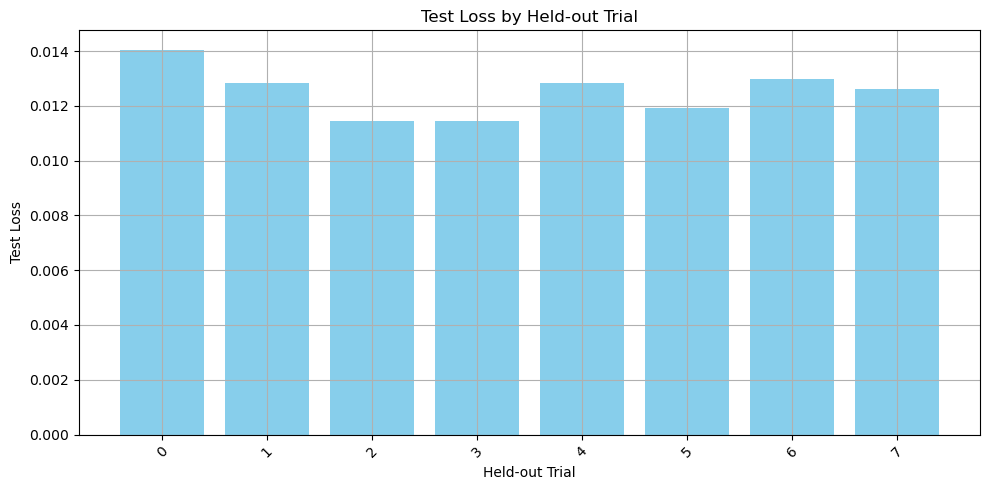

In [42]:
from viz import plot_cv_test_loss_bar
plot_cv_test_loss_bar(cv_results, SPLIT_STRATEGY, savepath=os.path.join(new_dir_path, 'cv_test_loss_bar.png'))




## Correlation plots of predicted vs. ground-truth snippets

In [43]:
# Compute z-score correlations for CV results
from viz import compute_cv_zscore_correlations

cv_results, overall_zscore_corr = compute_cv_zscore_correlations(
    cv_results=cv_results,
    cv_hparams=CV_HPARAMS,
    valid_df=valid_df,
    dfof=dfof,
    good_pairs=good_pairs,
    filter_neurons=FILTER_NEURONS,
    target_neurons=TARGET_NEURONS,
    device=device,
    model_dir=new_dir_path,
    input_size=input_size,
    output_size=output_size,
    initial_cond_size=initial_cond_size,
    snippet_length=SNIPPET_LENGTH,
    stim_delay=STIM_DELAY,
    window_size=50,
    save_dir=os.path.join(new_dir_path, 'zscore_corr_cv'),
    save_plots=True,  # Set to True to save individual plots
)

# Update CV summary with z-score correlations
cv_summary['fold_results'] = [{
    k: v for k, v in r.items() 
    if k not in ['history', 'test_outputs', 'zscore_correlations']
} for r in cv_results]
cv_summary['overall_zscore_corr'] = overall_zscore_corr
cv_summary['fold_zscore_corrs'] = [r.get('mean_zscore_corr', np.nan) for r in cv_results]

# Save updated summary
with open(cv_summary_path, 'w') as f:
    json.dump(cv_summary, f, indent=2, default=str)
logging.info(f"Updated CV summary with z-score correlations saved to {cv_summary_path}")

2026-01-21 11:50:15,826 INFO: Fold 1 | Holdout=0 | Mean Z-Corr=0.2106 (n=78)
2026-01-21 11:50:21,136 INFO: Fold 2 | Holdout=1 | Mean Z-Corr=0.2491 (n=78)
2026-01-21 11:50:25,585 INFO: Fold 3 | Holdout=2 | Mean Z-Corr=0.2198 (n=78)
2026-01-21 11:50:30,078 INFO: Fold 4 | Holdout=3 | Mean Z-Corr=0.1768 (n=78)
2026-01-21 11:50:34,595 INFO: Fold 5 | Holdout=4 | Mean Z-Corr=0.1910 (n=78)
2026-01-21 11:50:38,828 INFO: Fold 6 | Holdout=5 | Mean Z-Corr=0.1958 (n=78)
2026-01-21 11:50:43,525 INFO: Fold 7 | Holdout=6 | Mean Z-Corr=0.1807 (n=78)
2026-01-21 11:50:47,917 INFO: Fold 8 | Holdout=7 | Mean Z-Corr=0.1789 (n=78)
2026-01-21 11:50:47,917 INFO: Overall Mean Z-Score Correlation: 0.2003 ± 0.3401 (n=624)

Z-SCORE CORRELATION RESULTS (trial strategy)
  Fold  1 | Holdout=   0 | Z-Corr=0.2106
  Fold  2 | Holdout=   1 | Z-Corr=0.2491
  Fold  3 | Holdout=   2 | Z-Corr=0.2198
  Fold  4 | Holdout=   3 | Z-Corr=0.1768
  Fold  5 | Holdout=   4 | Z-Corr=0.1910
  Fold  6 | Holdout=   5 | Z-Corr=0.1958
  Fo


80th percentile thresholds for target neurons:
  ROI 1: 0.0774 df/F
  ROI 2: 0.0616 df/F
  ROI 3: 0.0591 df/F
  ROI 4: 0.1013 df/F
  ROI 5: 0.0580 df/F
  ROI 6: 0.0557 df/F
  ROI 7: 0.1356 df/F
  ROI 8: 0.0607 df/F
  ROI 9: 0.0584 df/F
  ROI 10: 0.0619 df/F
  ROI 11: 0.0872 df/F
  ROI 12: 0.0641 df/F
  ROI 13: 0.0554 df/F
  ROI 14: 0.0593 df/F
  ROI 15: 0.0624 df/F
  ROI 16: 0.1217 df/F
  ROI 17: 0.0917 df/F
  ROI 18: 0.0624 df/F
  ROI 19: 0.1093 df/F
  ROI 20: 0.0799 df/F
  ROI 21: 0.0611 df/F
  ROI 22: 0.0731 df/F
  ROI 23: 0.0665 df/F
  ROI 24: 0.0567 df/F
  ROI 25: 0.1048 df/F
  ROI 26: 0.1150 df/F
  ROI 27: 0.0763 df/F
  ROI 28: 0.0613 df/F
  ROI 29: 0.0619 df/F
  ROI 30: 0.0647 df/F
  ROI 31: 0.0715 df/F
  ROI 32: 0.1284 df/F
  ROI 33: 0.0740 df/F
  ROI 34: 0.0085 df/F
  ROI 35: 0.0524 df/F
  ROI 36: 0.0840 df/F
  ROI 37: 0.1575 df/F
  ROI 38: 0.0621 df/F
  ROI 39: 0.0587 df/F
  ROI 40: 0.0566 df/F
  ROI 41: 0.0952 df/F
  ROI 42: 0.0655 df/F
  ROI 43: 0.0910 df/F
  ROI 44: 0.154

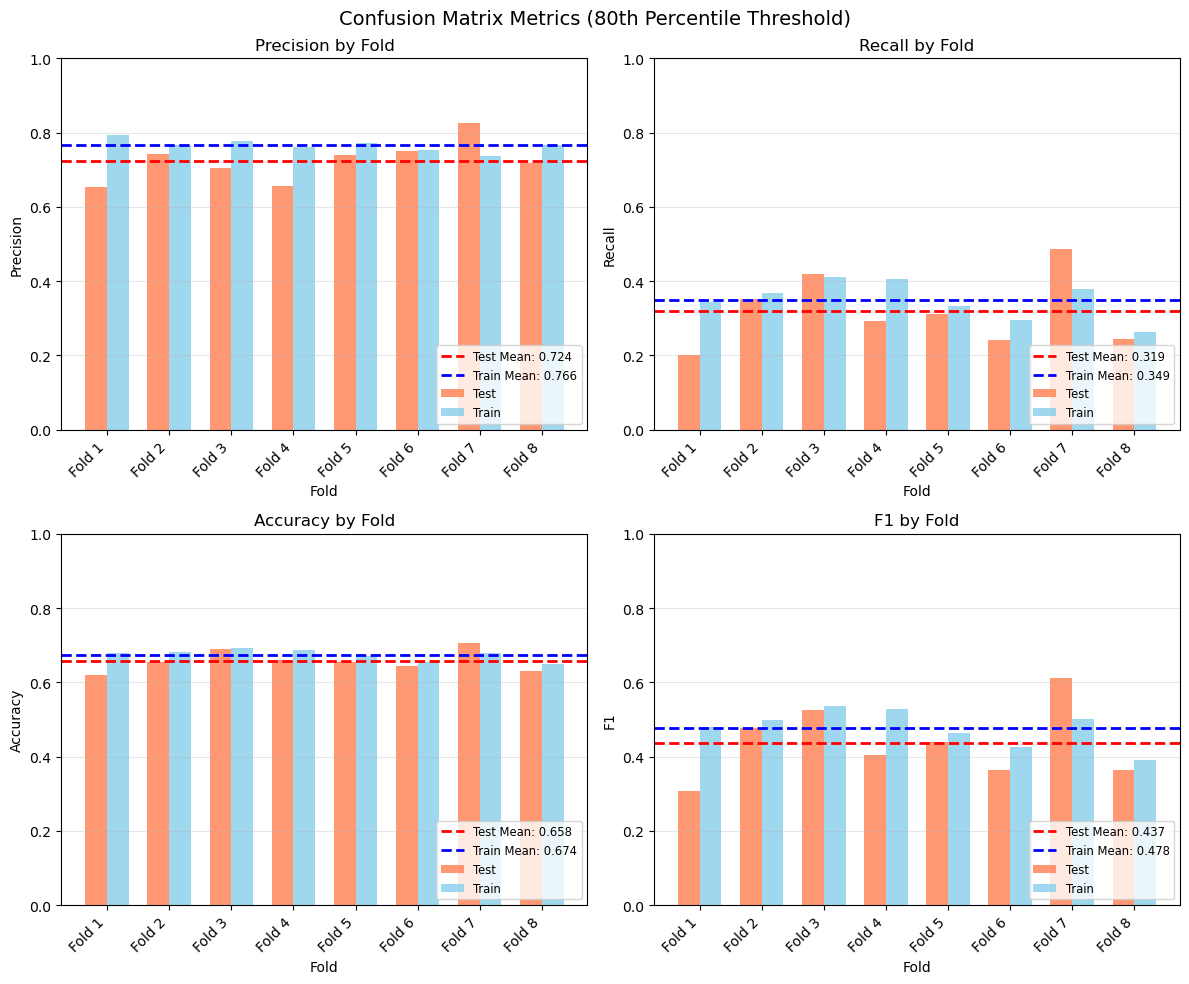

2026-01-21 11:51:21,052 INFO: Updated CV summary with confusion metrics saved to rnn_training/20260121_112939/cv_summary.json


In [44]:
# Compute confusion matrix metrics for CV results
from viz import compute_cv_confusion_metrics, plot_cv_confusion_summary, compute_roi_percentiles

# Set percentile threshold (e.g., 80th percentile means activity above this value is "active")
THRESHOLD_PERCENTILE = 80

# First, compute the thresholds to see what values they correspond to
roi_thresholds = compute_roi_percentiles(dfof, percentile=THRESHOLD_PERCENTILE, filter_neurons=FILTER_NEURONS)
print(f"\n{THRESHOLD_PERCENTILE}th percentile thresholds for target neurons:")
for roi in sorted(TARGET_NEURONS):
    if roi in roi_thresholds:
        print(f"  ROI {roi}: {roi_thresholds[roi]:.4f} df/F")

# Compute confusion metrics
cv_results, confusion_summary = compute_cv_confusion_metrics(
    cv_results=cv_results,
    cv_hparams=CV_HPARAMS,
    valid_df=valid_df,
    dfof=dfof,
    good_pairs=good_pairs,
    filter_neurons=FILTER_NEURONS,
    target_neurons=TARGET_NEURONS,
    device=device,
    model_dir=new_dir_path,
    input_size=input_size,
    output_size=output_size,
    initial_cond_size=initial_cond_size,
    snippet_length=SNIPPET_LENGTH,
    percentile=THRESHOLD_PERCENTILE,
    save_dir=os.path.join(new_dir_path, 'confusion_metrics'),
)

# Plot confusion metrics summary
plot_cv_confusion_summary(
    cv_results=cv_results,
    summary=confusion_summary,
    save_path=os.path.join(new_dir_path, f'confusion_summary_p{THRESHOLD_PERCENTILE}.png'),
)

# Update CV summary with confusion metrics
cv_summary['confusion_summary'] = {
    'percentile': THRESHOLD_PERCENTILE,
    'test_precision': confusion_summary['test']['mean_precision'],
    'test_recall': confusion_summary['test']['mean_recall'],
    'test_accuracy': confusion_summary['test']['mean_accuracy'],
    'test_f1': confusion_summary['test']['mean_f1'],
    'train_precision': confusion_summary['train']['mean_precision'],
    'train_recall': confusion_summary['train']['mean_recall'],
    'train_accuracy': confusion_summary['train']['mean_accuracy'],
    'train_f1': confusion_summary['train']['mean_f1'],
}

# Save updated summary
with open(cv_summary_path, 'w') as f:
    json.dump(cv_summary, f, indent=2, default=str)
logging.info(f"Updated CV summary with confusion metrics saved to {cv_summary_path}")

Plotting CV raster for Config 3, ROI 26
Using 80th percentile threshold: 0.1150
2026-01-21 11:51:21,552 INFO: Saved CV raster to rnn_training/20260121_112939/rasters_cv/raster_cv_c3_roi26.png


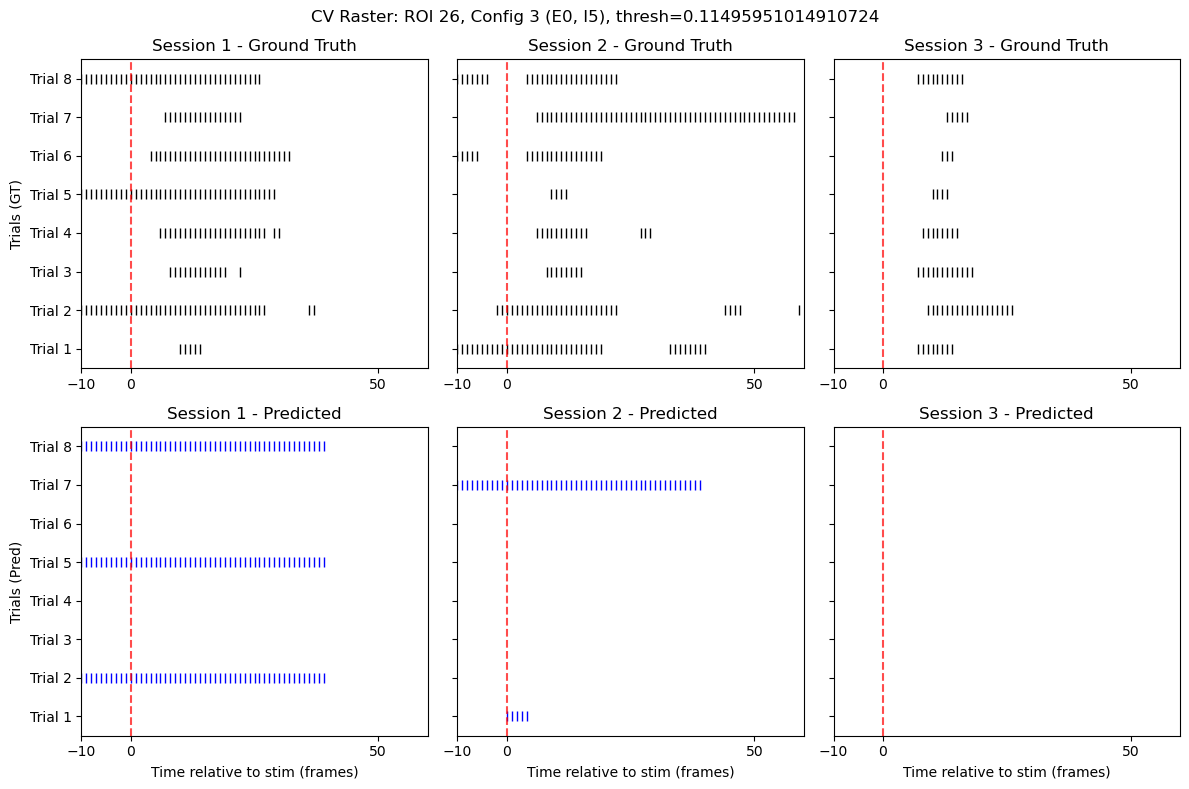

In [45]:
# Plot CV raster for a specific ROI and config
from viz import plot_stim_raster_cv

# Choose a (config, roi) pair from good_pairs to visualize
raster_config, raster_roi = good_pairs[0]  # e.g., (3, 26)

# Use the percentile threshold computed above
raster_threshold = roi_thresholds[raster_roi]

print(f"Plotting CV raster for Config {raster_config}, ROI {raster_roi}")
print(f"Using {THRESHOLD_PERCENTILE}th percentile threshold: {raster_threshold:.4f}")

os.makedirs(os.path.join(new_dir_path, 'rasters_cv'), exist_ok=True)

fig = plot_stim_raster_cv(
    cv_results=cv_results,
    cv_hparams=CV_HPARAMS,
    valid_df=valid_df,
    dfof=dfof,
    neuron=raster_roi,
    config=raster_config,
    filter_neurons=FILTER_NEURONS,
    target_neurons=TARGET_NEURONS,
    device=device,
    model_dir=new_dir_path,
    input_size=input_size,
    output_size=output_size,
    initial_cond_size=initial_cond_size,
    snippet_length=SNIPPET_LENGTH,
    threshold=raster_threshold,
    pre_stim_frames=10,
    post_stim_frames=60,
    sessions=[0, 1, 2],
    save_path=os.path.join(new_dir_path, 'rasters_cv', f'raster_cv_c{raster_config}_roi{raster_roi}.png'),
)
plt.show()

## PSTHs like Yuxuans

2026-01-21 11:51:21,706 INFO: CV split strategy: trial
2026-01-21 11:51:21,706 INFO: Holdout elements: [0, 1, 2, 3, 4, 5, 6, 7]
2026-01-21 11:51:21,707 INFO: Config 1: 24 snippets, neurons: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]


KeyboardInterrupt: 

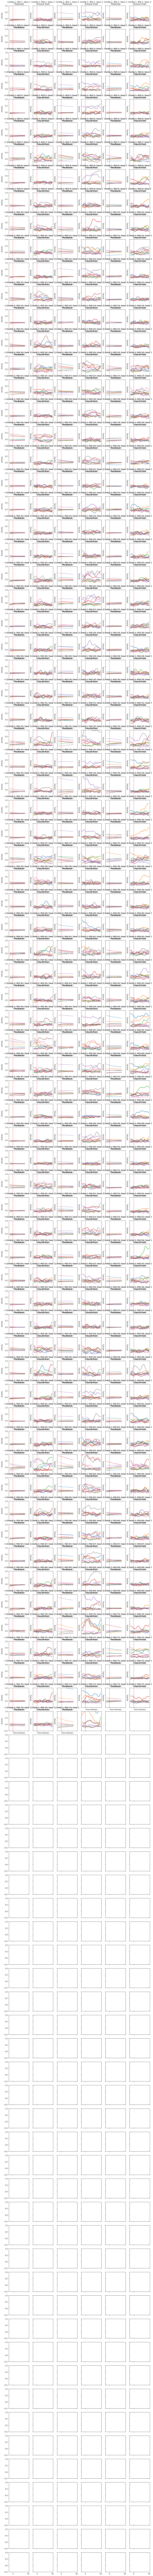

In [46]:
from viz import plot_psth_from_cv_results


# Run the CV-based PSTH plotting
import pandas as pd
neurons_by_config = {}
for pair in good_pairs:
    if neurons_by_config.get(str(pair[0])) is None:
        neurons_by_config[str(pair[0])] = [pair[1]]
    else:
        neurons_by_config[str(pair[0])].append(pair[1])
default_neurons = TARGET_NEURONS  # Use all target neurons if no config-specific set



# Only plot neurons that are in TARGET_NEURONS (since model only predicts those)
# neurons_of_interest = [n for n in neurons_of_interest if n in TARGET_NEURONS]

plot_psth_from_cv_results(
    cv_results=cv_results,
    cv_hparams=CV_HPARAMS,
    valid_df=valid_df,
    dfof=dfof,
    configs_to_plot=configs_to_plot if 'configs_to_plot' in dir() else list(range(1, 32)),
    neurons_by_config=neurons_by_config,
    filter_neurons=FILTER_NEURONS,
    target_neurons=TARGET_NEURONS,
    device=device,
    model_dir=new_dir_path,
    input_size=input_size,
    output_size=output_size,
    initial_cond_size=initial_cond_size,
    snippet_length=SNIPPET_LENGTH,
    stim_delay=STIM_DELAY,
    post_stim_frames=50,
    subplot_size=2.5,
    show_ground_truth=True,
    line_alpha=0.9,
    pred_lw=1.2,
    gt_lw=2.0,
    n_sessions=3,
    save_dir=os.path.join(new_dir_path, 'psths_cv'),
)



## Loss over Epochs Plot

Plotting losses for Fold 1 (holdout=0)


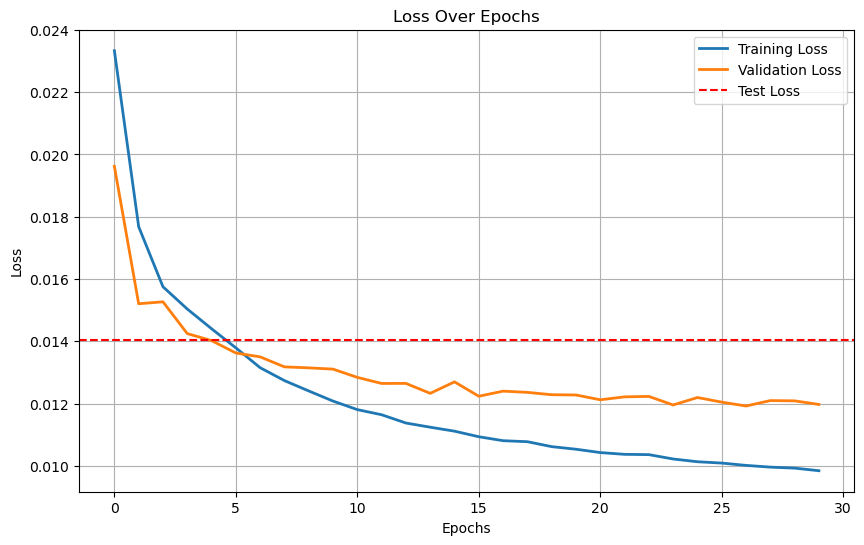

Plotting losses for Fold 2 (holdout=1)


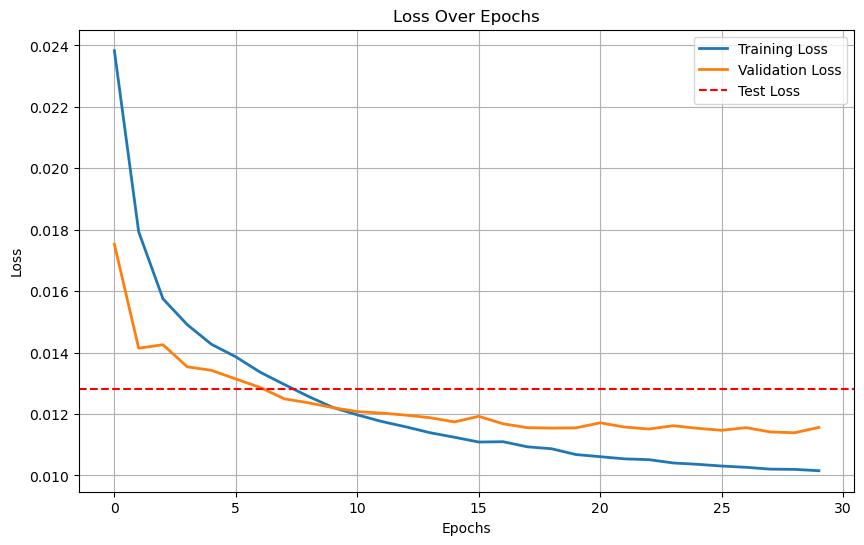

Plotting losses for Fold 3 (holdout=2)


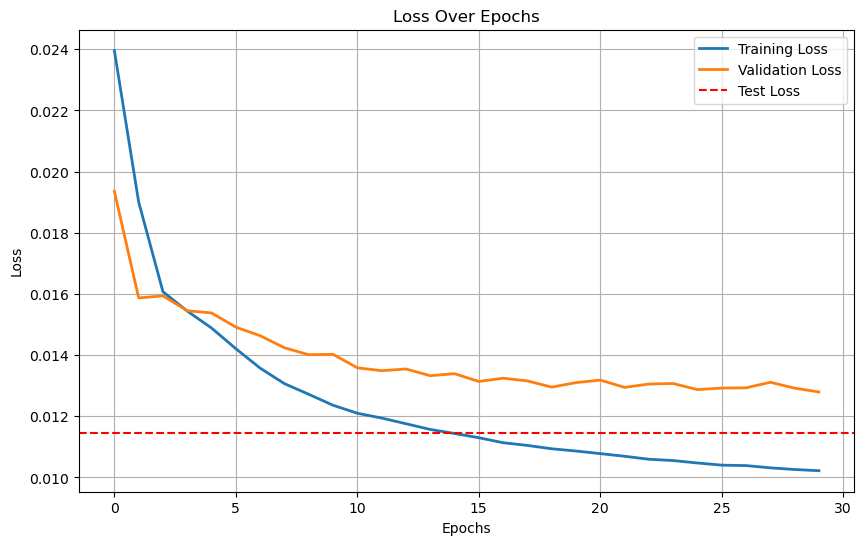

Plotting losses for Fold 4 (holdout=3)


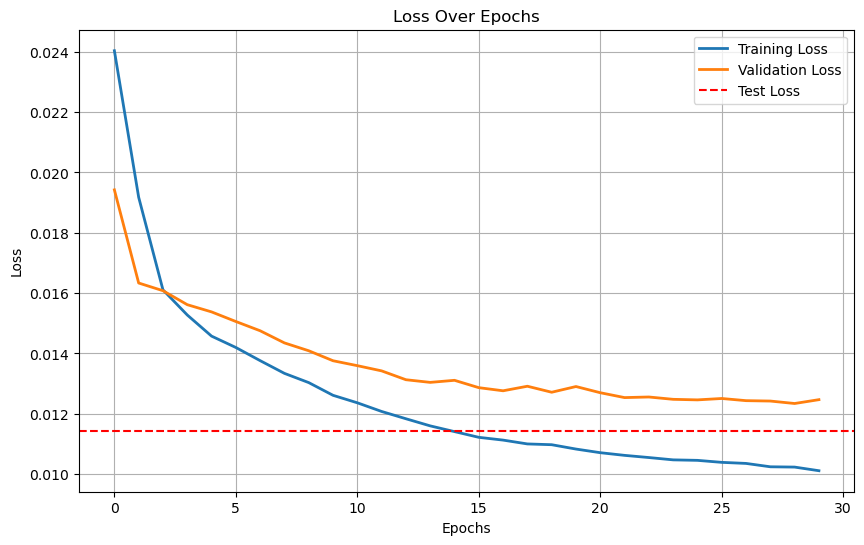

Plotting losses for Fold 5 (holdout=4)


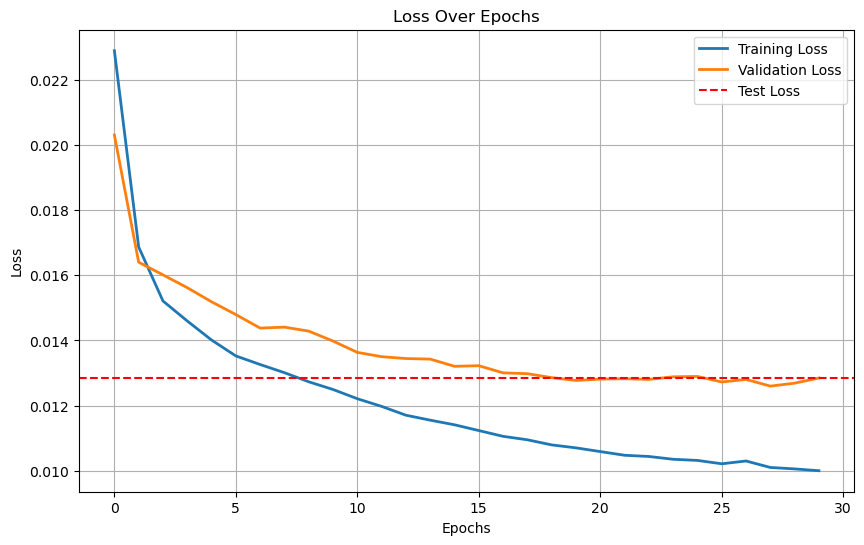

Plotting losses for Fold 6 (holdout=5)


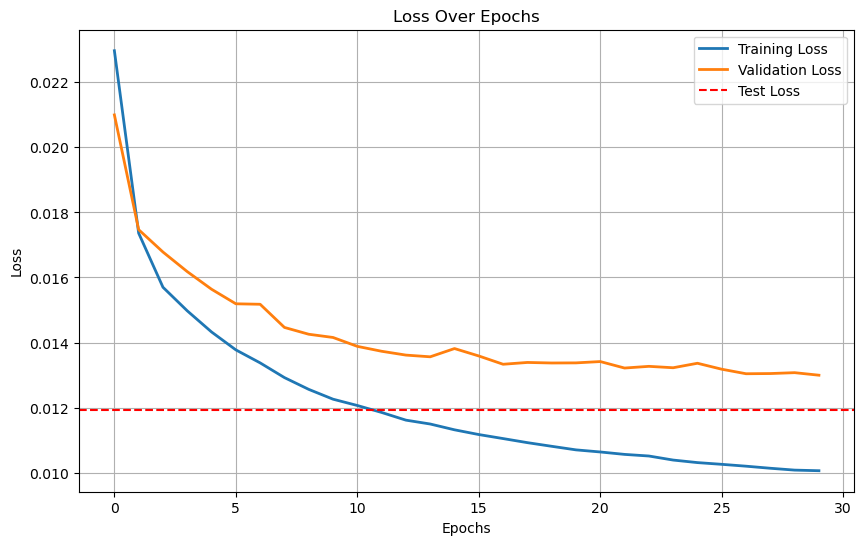

Plotting losses for Fold 7 (holdout=6)


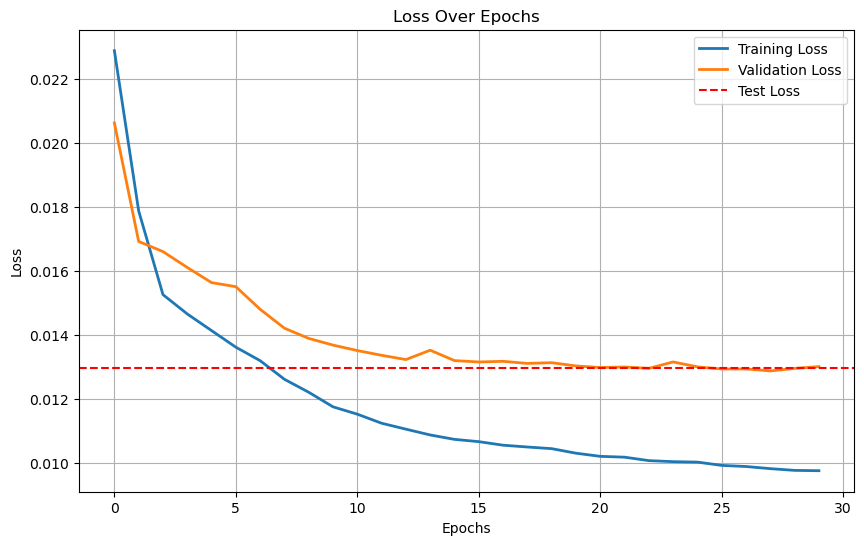

Plotting losses for Fold 8 (holdout=7)


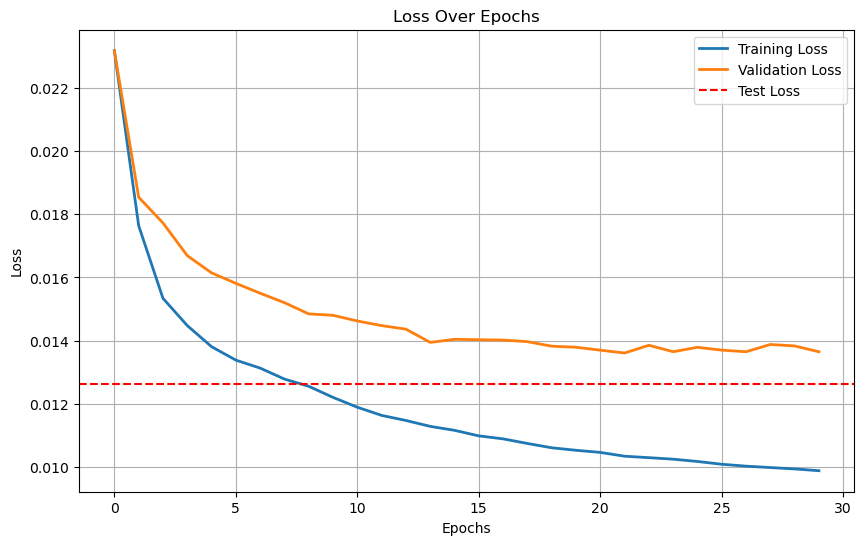


All CV loss plots saved to: rnn_training/20260121_112939/cv_losses


In [47]:
# Plot losses for each fold in cross-validation
from viz import plot_losses

# Create directory for CV loss plots
cv_losses_dir = os.path.join(new_dir_path, 'cv_losses')
os.makedirs(cv_losses_dir, exist_ok=True)

for r in cv_results:
    fold_idx = r['fold']
    holdout_elem = r['holdout_element']
    fold_history = r.get('history', None)
    fold_test_loss = r.get('test_loss', None)
    
    if fold_history is None:
        logging.warning(f"Fold {fold_idx}: No history found, skipping loss plot")
        continue
    
    # Create fold-specific save path
    fold_savepath = os.path.join(cv_losses_dir, f'fold_{fold_idx}_holdout_{holdout_elem}')
    os.makedirs(fold_savepath, exist_ok=True)
    
    print(f"Plotting losses for Fold {fold_idx} (holdout={holdout_elem})")
    plot_losses(fold_history, fold_test_loss, savepath=fold_savepath)

print(f"\nAll CV loss plots saved to: {cv_losses_dir}")

NameError: name 'HOLDOUT_TRIALS' is not defined

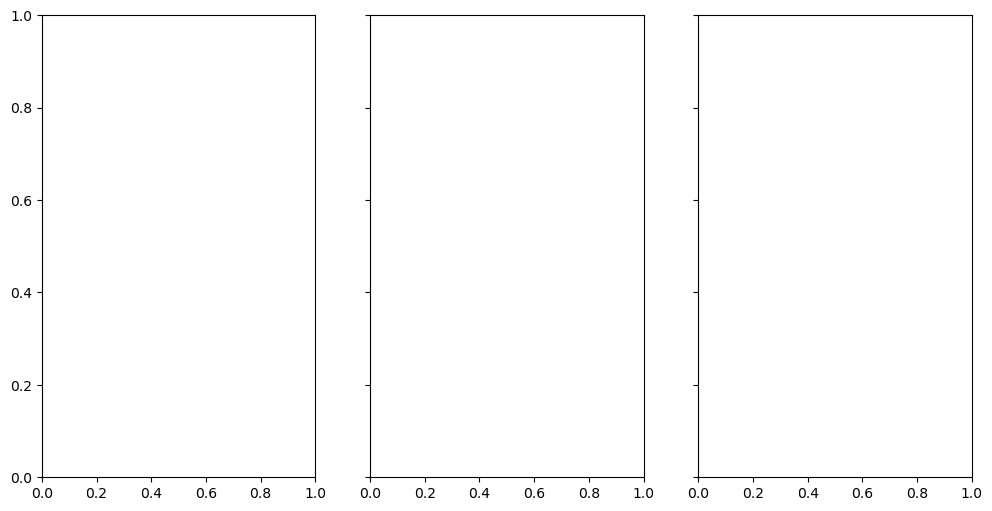

In [48]:
from viz import plot_stim_raster
# Example usage:
# plot_stim_raster(neuron=31, config=27, threshold=0.1)
if not os.path.exists(os.path.join(new_dir_path, "rasters")):
    os.makedirs(os.path.join(new_dir_path, "rasters"))
plot_stim_raster(trials_df, dfof, neuron=31, config=27, threshold=0.25, save_path=os.path.join(new_dir_path, "rasters", "n31_c28_t0.1.png"))

Generating: Config 3, Neuron 26, Threshold 0.1


NameError: name 'HOLDOUT_TRIALS' is not defined

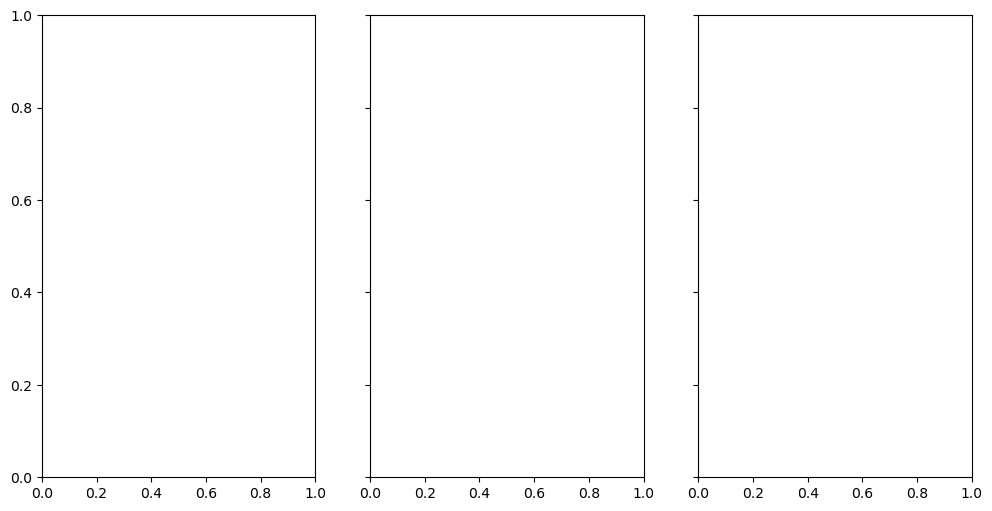

In [ ]:
# # Generate rasters for all good_pairs at multiple thresholds
# # good_pairs format: (config, neuron)
# thresholds = [0.1, 0.2, 0.3]

# # Create rasters directory
# rasters_dir = os.path.join(new_dir_path, "rasters")
# os.makedirs(rasters_dir, exist_ok=True)

# for config, neuron in good_pairs:
#     for thresh in thresholds:
#         save_name = f"raster_c{config}_n{neuron}_t{thresh}.png"
#         save_path = os.path.join(rasters_dir, save_name)
#         print(f"Generating: Config {config}, Neuron {neuron}, Threshold {thresh}")
#         plot_stim_raster(trials_df=trials_df, dfof=dfof, neuron=neuron, config=config, threshold=thresh, save_path=save_path)
#         plt.close()

# print(f"\nSaved {len(good_pairs) * len(thresholds)} raster plots to {rasters_dir}")

Config 1: Electrode 0, Current 3
Config 2: Electrode 0, Current 4
Config 3: Electrode 0, Current 5
Config 4: Electrode 1, Current 3
Config 5: Electrode 1, Current 4
Config 6: Electrode 1, Current 5
Config 7: Electrode 2, Current 3
Config 8: Electrode 2, Current 4
Config 9: Electrode 2, Current 5
Config 10: Electrode 3, Current 3
Config 11: Electrode 3, Current 4
Config 12: Electrode 3, Current 5
Config 13: Electrode 4, Current 3
Config 14: Electrode 4, Current 4
Config 15: Electrode 4, Current 5
Config 16: Electrode 5, Current 3
Config 17: Electrode 5, Current 4
Config 18: Electrode 5, Current 5
Config 19: Electrode 6, Current 3
Config 20: Electrode 6, Current 4
Config 21: Electrode 6, Current 5
Config 22: Electrode 7, Current 3
Config 23: Electrode 7, Current 4
Config 24: Electrode 7, Current 5
Config 25: Electrode 8, Current 3
Config 26: Electrode 8, Current 4
Config 27: Electrode 8, Current 5
Config 28: Electrode 9, Current 3
Config 29: Electrode 9, Current 4
Config 30: Electrode 9,

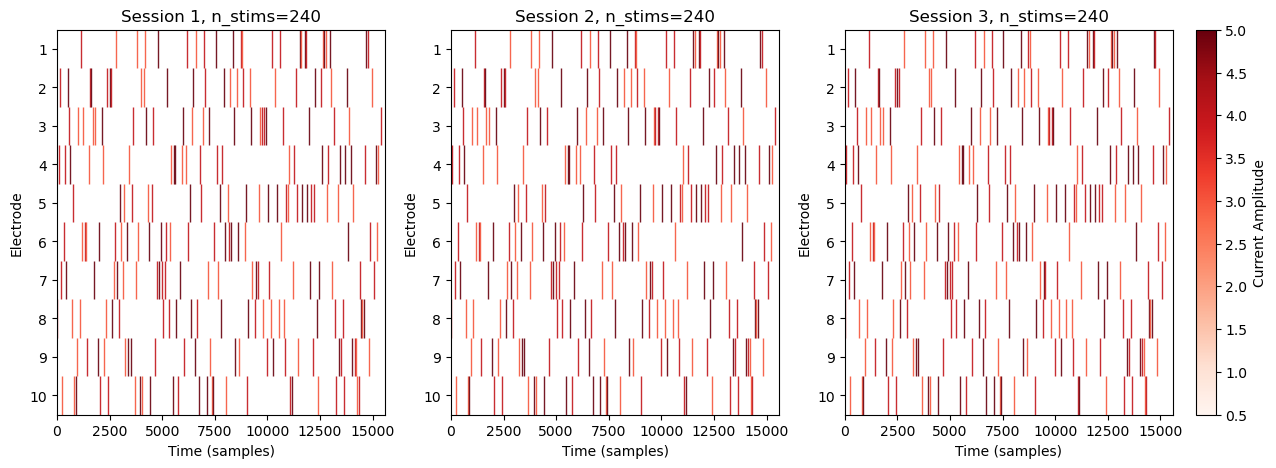

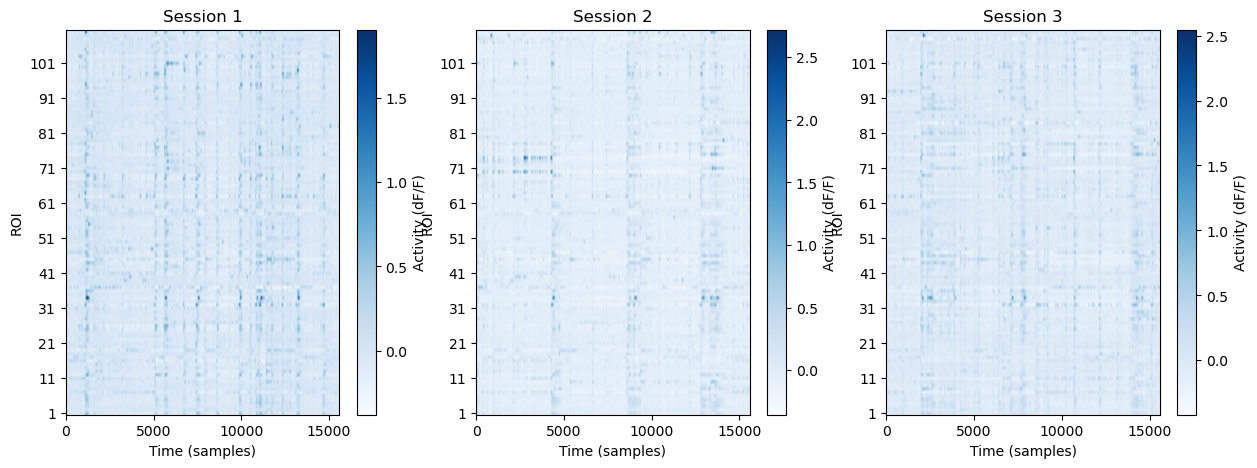

In [19]:
from viz import plot_stim_ticks, plot_activity_per_session
stim_times_sess = []
for session in range(3):
    stim_times = np.zeros((dfof[session].shape[0], 10))
    for config in range(1, 31): # last config is no stim
        electrode = (config-1) // 3
        current = (config-1)%3 + 3
        print(f'Config {config}: Electrode {electrode}, Current {current}')
        for i in range(8):
            config_time = times[session][i,config-1]
            stim_times[config_time, electrode] = current
    stim_times_sess.append(stim_times) # len 3, each (n_times, n_electrodes)

stim_times_sess = np.array(stim_times_sess)
print ("Stim times sess shape: ", stim_times_sess.shape)

# how many frames have no stimulation?
n_no_stim = [stim_times_sess[i].shape[0] - np.count_nonzero(stim_times_sess[i]) for i in range(3)]
print (f'Number of no-stim frames per session: {",".join([str(n) for n in n_no_stim])} assuming 1 ms current pulse')




plot_stim_ticks(stim_times_sess, session_ids=None, tick_width=6, cmap_name='Reds',
                figsize=(15, 5), out_path=f'rnn_training/{DATETIME_STAMP}/stim_times_sessions_ticks.png',
                invert_y=True)

plot_activity_per_session(dfof, session_ids=None,
                          figsize=(15,5),
                          out_path=f'rnn_training/{DATETIME_STAMP}/activity_sessions.png')

In [ ]:
## Shuffled Initial Condition Experiment
Evaluate the importance of initial conditions by shuffling them across the batch and measuring degradation in prediction performance.

In [ ]:
import torch
import numpy as np
import copy
from tqdm.notebook import tqdm
from utils import get_inputs_outputs_targets, create_split_dfs
from modules import RNNModel, SeqDataset
from torch.utils.data import DataLoader

def evaluate_with_shuffled_h0(model, loader, criterion, device, loss_type='mse', shuffle_mode='full'):
    """
    Evaluate model performance with shuffled initial conditions.
    
    Args:
        model: Trained RNN model (in eval mode).
        loader: DataLoader with test data.
        criterion: Loss function.
        device: torch device.
        loss_type: 'mse', 'mae', or 'weighted_mae'.
        shuffle_mode: 'full' shuffles entire h0 vector, 'per_neuron' shuffles each neuron independently.
    
    Returns:
        shuffled_loss: Loss with shuffled initial conditions.
        outputs: Model predictions with shuffled h0.
    """
    model.eval()
    total_loss = 0.0
    outputs_collection = []
    
    with torch.no_grad():
        for (inputs, activity_initial), targets in loader:
            inputs = inputs.to(device)
            activity_initial = activity_initial.to(device)
            targets = targets.to(device)
            
            batch_size = activity_initial.shape[0]
            
            if shuffle_mode == 'full':
                # Shuffle entire h0 vectors across batch
                perm_indices = torch.randperm(batch_size, device=device)
                activity_initial_shuffled = activity_initial[perm_indices]
            elif shuffle_mode == 'per_neuron':
                # Shuffle each neuron dimension independently
                activity_initial_shuffled = activity_initial.clone()
                for neuron_idx in range(activity_initial.shape[1]):
                    perm_indices = torch.randperm(batch_size, device=device)
                    activity_initial_shuffled[:, neuron_idx] = activity_initial[perm_indices, neuron_idx]
            else:
                raise ValueError(f"Unknown shuffle_mode: {shuffle_mode}")
            
            outputs = model((inputs, activity_initial_shuffled))
            outputs_collection.append(outputs.cpu().numpy())
            
            if loss_type == 'weighted_mae':
                loss = criterion(outputs, targets, inputs)
            else:
                loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
    
    shuffled_loss = total_loss / len(loader.dataset)
    outputs_collection = np.concatenate(outputs_collection, axis=0)
    return shuffled_loss, outputs_collection


def calculate_h0_neuron_importance(model, loader, criterion, device, loss_type='mse', n_permutations=5):
    """
    Computes permutation importance for each neuron in the initial condition.
    
    Args:
        model: Trained RNN model (in eval mode).
        loader: DataLoader with test data.
        criterion: Loss function.
        device: torch device.
        loss_type: 'mse', 'mae', or 'weighted_mae'.
        n_permutations: Number of random permutations to average over.
    
    Returns:
        baseline_loss: Loss with original initial conditions.
        importances: Array where index i is the importance (delta loss) of neuron i.
    """
    model.eval()
    
    # Collect all data from loader
    all_inputs = []
    all_h0 = []
    all_targets = []
    
    for (inputs, activity_initial), targets in loader:
        all_inputs.append(inputs)
        all_h0.append(activity_initial)
        all_targets.append(targets)
    
    all_inputs = torch.cat(all_inputs, dim=0).to(device)
    all_h0 = torch.cat(all_h0, dim=0).to(device)
    all_targets = torch.cat(all_targets, dim=0).to(device)
    
    n_samples = all_inputs.shape[0]
    n_neurons = all_h0.shape[1]
    
    # 1. Get Baseline Performance
    with torch.no_grad():
        pred_baseline = model((all_inputs, all_h0))
        if loss_type == 'weighted_mae':
            baseline_loss = criterion(pred_baseline, all_targets, all_inputs).item()
        else:
            baseline_loss = criterion(pred_baseline, all_targets).item()
    
    print(f"Baseline Loss: {baseline_loss:.6f}")
    
    # 2. Iterate through each neuron
    importances = np.zeros(n_neurons)
    
    for neuron_idx in tqdm(range(n_neurons), desc="Neuron importance"):
        perm_losses = []
        
        for _ in range(n_permutations):
            # Create a copy of h0 to modify
            h0_perturbed = all_h0.clone()
            
            # Shuffle the neuron_idx column across all samples
            perm_indices = torch.randperm(n_samples, device=device)
            h0_perturbed[:, neuron_idx] = all_h0[perm_indices, neuron_idx]
            
            # Run inference with perturbed h0
            with torch.no_grad():
                pred_perturbed = model((all_inputs, h0_perturbed))
                if loss_type == 'weighted_mae':
                    perturbed_loss = criterion(pred_perturbed, all_targets, all_inputs).item()
                else:
                    perturbed_loss = criterion(pred_perturbed, all_targets).item()
            
            perm_losses.append(perturbed_loss)
        
        # Average across permutations
        mean_perturbed_loss = np.mean(perm_losses)
        
        # Calculate importance (increase in loss when neuron is shuffled)
        importances[neuron_idx] = mean_perturbed_loss - baseline_loss
    
    return baseline_loss, importances

In [ ]:
# =====================================================
# Run Shuffled H0 Experiment on Same CV Folds
# =====================================================
# Re-use the same cross-validation splits and trained models to evaluate 
# the effect of shuffling initial conditions

shuffled_cv_results = []

for fold_idx, holdout_element in enumerate(tqdm(fold_elements, desc="Shuffled H0 CV Folds")):
    # Skip folds that were skipped in original CV
    if fold_idx >= len(cv_results) or cv_results[fold_idx]['holdout_element'] != holdout_element:
        # Find matching fold in cv_results
        matching = [r for r in cv_results if r['holdout_element'] == holdout_element]
        if not matching:
            print(f"Skipping fold {fold_idx + 1}: holdout={holdout_element} not in cv_results")
            continue
    
    print(f"\n{'='*60}")
    print(f"FOLD {fold_idx + 1}/{n_folds}: Shuffled H0 for {CV_HPARAMS['split_strategy']}={holdout_element}")
    print(f"{'='*60}")
    
    # Recreate the same data splits
    holdout_kwargs = {
        'holdout_sessions': [],
        'holdout_trials': [],
        'holdout_configs': [],
        'holdout_electrodes': [],
        'holdout_currents': [],
    }
    holdout_kwargs[holdout_key] = [holdout_element]
    
    fold_train_df, fold_val_df, fold_test_df = create_split_dfs(
        split_strategy=CV_HPARAMS['split_strategy'],
        valid_df=valid_df.copy(),
        trials_df=trials_df,
        sessions=sessions,
        snippet_length=CV_HPARAMS['snippet_length'],
        val_size=CV_HPARAMS['val_size'],
        seed=CV_HPARAMS['seed'],
        **holdout_kwargs
    )
    
    if len(fold_test_df) == 0:
        print(f"Fold {fold_idx + 1}: Empty test set, skipping.")
        continue
    
    # Create test dataset and loader
    fold_test_ds = SeqDataset(df=fold_test_df, target_indices=target_indices)
    fold_test_loader = DataLoader(fold_test_ds, batch_size=CV_HPARAMS['batch_size'], 
                                  shuffle=False, pin_memory=True)
    
    # Load the trained model for this fold
    fold_checkpoint = os.path.join(new_dir_path, f"cv_fold_{fold_idx}_best.pth")
    
    if not os.path.exists(fold_checkpoint):
        print(f"Checkpoint not found: {fold_checkpoint}, skipping fold.")
        continue
    
    fold_model = RNNModel(
        input_size=input_size, 
        units=CV_HPARAMS['n_units'], 
        output_size=output_size,
        num_layers=CV_HPARAMS['num_layers'], 
        initial_cond_size=initial_cond_size
    ).to(device)
    fold_model.load_state_dict(torch.load(fold_checkpoint, map_location=device))
    fold_model.eval()
    
    # Set up criterion
    if CV_HPARAMS['loss_type'] == 'mae':
        fold_criterion = nn.L1Loss()
    elif CV_HPARAMS['loss_type'] == 'weighted_mae':
        from modules import WeightedMAELoss
        fold_criterion = WeightedMAELoss(stim_weight=5.0, window=15, decay='none')
    else:
        fold_criterion = nn.MSELoss()
    
    # Get baseline (original) test loss for comparison
    baseline_loss, baseline_outputs = get_model_error(fold_model, fold_test_loader, fold_criterion, 
                                                       device, CV_HPARAMS['loss_type'])
    
    # Evaluate with shuffled h0 (full shuffle)
    shuffled_full_loss, shuffled_full_outputs = evaluate_with_shuffled_h0(
        fold_model, fold_test_loader, fold_criterion, device, 
        loss_type=CV_HPARAMS['loss_type'], shuffle_mode='full'
    )
    
    # Evaluate with shuffled h0 (per-neuron shuffle)  
    shuffled_perneuron_loss, shuffled_perneuron_outputs = evaluate_with_shuffled_h0(
        fold_model, fold_test_loader, fold_criterion, device,
        loss_type=CV_HPARAMS['loss_type'], shuffle_mode='per_neuron'
    )
    
    print(f"  Baseline Loss:         {baseline_loss:.6f}")
    print(f"  Shuffled (full) Loss:  {shuffled_full_loss:.6f} (Δ = {shuffled_full_loss - baseline_loss:+.6f})")
    print(f"  Shuffled (per-neuron): {shuffled_perneuron_loss:.6f} (Δ = {shuffled_perneuron_loss - baseline_loss:+.6f})")
    
    shuffled_cv_results.append({
        'fold': fold_idx + 1,
        'holdout_element': holdout_element,
        'test_size': len(fold_test_df),
        'baseline_loss': baseline_loss,
        'shuffled_full_loss': shuffled_full_loss,
        'shuffled_perneuron_loss': shuffled_perneuron_loss,
        'delta_full': shuffled_full_loss - baseline_loss,
        'delta_perneuron': shuffled_perneuron_loss - baseline_loss,
    })

print("\n" + "="*70)
print("SHUFFLED H0 EXPERIMENT COMPLETE")
print("="*70)

In [ ]:
# =====================================================
# Summarize Shuffled H0 Results
# =====================================================
import pandas as pd

shuffled_df = pd.DataFrame(shuffled_cv_results)
print("\nShuffled Initial Condition Results Summary:")
print(shuffled_df.to_string(index=False))

print("\n" + "-"*70)
print(f"Mean Baseline Loss:          {shuffled_df['baseline_loss'].mean():.6f} ± {shuffled_df['baseline_loss'].std():.6f}")
print(f"Mean Shuffled (full) Loss:   {shuffled_df['shuffled_full_loss'].mean():.6f} ± {shuffled_df['shuffled_full_loss'].std():.6f}")
print(f"Mean Shuffled (per-neuron):  {shuffled_df['shuffled_perneuron_loss'].mean():.6f} ± {shuffled_df['shuffled_perneuron_loss'].std():.6f}")
print(f"\nMean Δ (full shuffle):       {shuffled_df['delta_full'].mean():+.6f} ± {shuffled_df['delta_full'].std():.6f}")
print(f"Mean Δ (per-neuron shuffle): {shuffled_df['delta_perneuron'].mean():+.6f} ± {shuffled_df['delta_perneuron'].std():.6f}")

# Save results
shuffled_results_path = os.path.join(new_dir_path, 'shuffled_h0_results.csv')
shuffled_df.to_csv(shuffled_results_path, index=False)
print(f"\nResults saved to: {shuffled_results_path}")

In [ ]:
# =====================================================
# Plot: Baseline vs Shuffled Loss Comparison
# =====================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot comparing losses across folds
x = np.arange(len(shuffled_df))
width = 0.25

ax = axes[0]
ax.bar(x - width, shuffled_df['baseline_loss'], width, label='Baseline', color='steelblue')
ax.bar(x, shuffled_df['shuffled_full_loss'], width, label='Shuffled (full)', color='coral')
ax.bar(x + width, shuffled_df['shuffled_perneuron_loss'], width, label='Shuffled (per-neuron)', color='mediumseagreen')
ax.set_xlabel(f'Holdout {CV_HPARAMS["split_strategy"].capitalize()}')
ax.set_ylabel('Test Loss')
ax.set_title('Effect of Shuffling Initial Conditions on Test Loss')
ax.set_xticks(x)
ax.set_xticklabels([str(h) for h in shuffled_df['holdout_element']], rotation=45)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Delta plot
ax2 = axes[1]
ax2.bar(x - width/2, shuffled_df['delta_full'], width, label='Δ Full Shuffle', color='coral')
ax2.bar(x + width/2, shuffled_df['delta_perneuron'], width, label='Δ Per-Neuron Shuffle', color='mediumseagreen')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel(f'Holdout {CV_HPARAMS["split_strategy"].capitalize()}')
ax2.set_ylabel('Δ Loss (Shuffled - Baseline)')
ax2.set_title('Loss Increase Due to Shuffled Initial Conditions')
ax2.set_xticks(x)
ax2.set_xticklabels([str(h) for h in shuffled_df['holdout_element']], rotation=45)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(new_dir_path, 'shuffled_h0_comparison.png'), dpi=150)
plt.show()

In [ ]:
# =====================================================
# Per-Neuron Importance Analysis (Optional - Runs on One Fold)
# =====================================================
# Pick a representative fold for detailed neuron importance analysis
# This shows which neurons in the initial condition contribute most to predictions

IMPORTANCE_FOLD_IDX = 0  # Change this to analyze a different fold

# Find the fold in cv_results
if IMPORTANCE_FOLD_IDX < len(cv_results):
    holdout_element = cv_results[IMPORTANCE_FOLD_IDX]['holdout_element']
    print(f"Analyzing neuron importance for fold {IMPORTANCE_FOLD_IDX + 1} (holdout={holdout_element})")
    
    # Recreate data splits
    holdout_kwargs = {
        'holdout_sessions': [],
        'holdout_trials': [],
        'holdout_configs': [],
        'holdout_electrodes': [],
        'holdout_currents': [],
    }
    holdout_kwargs[holdout_key] = [holdout_element]
    
    fold_train_df, fold_val_df, fold_test_df = create_split_dfs(
        split_strategy=CV_HPARAMS['split_strategy'],
        valid_df=valid_df.copy(),
        trials_df=trials_df,
        sessions=sessions,
        snippet_length=CV_HPARAMS['snippet_length'],
        val_size=CV_HPARAMS['val_size'],
        seed=CV_HPARAMS['seed'],
        **holdout_kwargs
    )
    
    fold_test_ds = SeqDataset(df=fold_test_df, target_indices=target_indices)
    fold_test_loader = DataLoader(fold_test_ds, batch_size=CV_HPARAMS['batch_size'], 
                                  shuffle=False, pin_memory=True)
    
    # Load model
    fold_checkpoint = os.path.join(new_dir_path, f"cv_fold_{IMPORTANCE_FOLD_IDX}_best.pth")
    fold_model = RNNModel(
        input_size=input_size, 
        units=CV_HPARAMS['n_units'], 
        output_size=output_size,
        num_layers=CV_HPARAMS['num_layers'], 
        initial_cond_size=initial_cond_size
    ).to(device)
    fold_model.load_state_dict(torch.load(fold_checkpoint, map_location=device))
    fold_model.eval()
    
    # Set up criterion
    if CV_HPARAMS['loss_type'] == 'mae':
        fold_criterion = nn.L1Loss()
    elif CV_HPARAMS['loss_type'] == 'weighted_mae':
        from modules import WeightedMAELoss
        fold_criterion = WeightedMAELoss(stim_weight=5.0, window=15, decay='none')
    else:
        fold_criterion = nn.MSELoss()
    
    # Calculate per-neuron importance
    baseline_loss, neuron_importances = calculate_h0_neuron_importance(
        fold_model, fold_test_loader, fold_criterion, device,
        loss_type=CV_HPARAMS['loss_type'], n_permutations=10
    )
    
    print(f"\nTop 10 most important neurons in initial condition:")
    top_neurons = np.argsort(neuron_importances)[::-1][:10]
    for rank, neuron_idx in enumerate(top_neurons):
        print(f"  {rank+1}. Neuron {neuron_idx}: Δ Loss = {neuron_importances[neuron_idx]:+.6f}")
else:
    print(f"Fold index {IMPORTANCE_FOLD_IDX} not available in cv_results")

In [ ]:
# =====================================================
# Plot Per-Neuron Importance
# =====================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of all neuron importances
ax = axes[0]
sorted_indices = np.argsort(neuron_importances)[::-1]
ax.bar(range(len(neuron_importances)), neuron_importances[sorted_indices], color='steelblue')
ax.set_xlabel('Neuron (sorted by importance)')
ax.set_ylabel('Δ Loss when shuffled')
ax.set_title(f'Initial Condition Neuron Importance (Fold {IMPORTANCE_FOLD_IDX + 1})')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.grid(axis='y', alpha=0.3)

# Top 15 neurons
ax2 = axes[1]
top_n = 15
top_indices = sorted_indices[:top_n]
colors = ['coral' if imp > 0 else 'mediumseagreen' for imp in neuron_importances[top_indices]]
ax2.barh(range(top_n), neuron_importances[top_indices], color=colors)
ax2.set_yticks(range(top_n))
ax2.set_yticklabels([f'Neuron {i}' for i in top_indices])
ax2.set_xlabel('Δ Loss when shuffled')
ax2.set_title(f'Top {top_n} Most Important Initial Condition Neurons')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(new_dir_path, 'h0_neuron_importance.png'), dpi=150)
plt.show()

# Save neuron importances
importance_df = pd.DataFrame({
    'neuron_idx': range(len(neuron_importances)),
    'importance': neuron_importances
}).sort_values('importance', ascending=False)
importance_df.to_csv(os.path.join(new_dir_path, 'h0_neuron_importance.csv'), index=False)
print(f"Neuron importance saved to: {os.path.join(new_dir_path, 'h0_neuron_importance.csv')}")